# Análisis en agricultura:
## Autor: Caleb Ventura

In [1]:
#librerías necesarias

from __future__ import division, print_function, unicode_literals
from numpy import *
import numpy as np
import matplotlib.pyplot as mplot
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib as mpl
import pandas as pd
import seaborn as sns #Need to install
import scipy.stats as stats
import pylab
import warnings
warnings.filterwarnings('ignore')
from itertools import cycle
from sklearn.cluster import KMeans as km
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso as LS
from sklearn.linear_model import Ridge as RG
from sklearn.tree import DecisionTreeRegressor as scart
from sklearn.manifold import TSNE
%matplotlib inline

# Lectura y limpieza de datos
#### 1. Leyendo el archivo principal de datos agrícolas :
- Base de datos principal que tiene información sobre el área de cultivo y la producción de cada estado desde 1997..

In [2]:
# Leer csv: contiene datos principales
#crop_prod: variable
crop_prod=pd.read_csv('apy.csv',delimiter=',')

# fillna reemplaza los NaN por ceros (0)
crop_prod=crop_prod.fillna(0)
#crop_prod.head(6)
#imprime los tipos de datos que contiene apy.csv
#print(crop_prod.dtypes)

In [3]:
#Ordenamiento segun columna 0
crop_prod.sort_values(by=crop_prod.columns[0])

#fila 0 al 6, 3ra columna

#states (Estados) es la lista ordenada de la columna 0
#Este algoritmo permite enlistar de forma ordenada con "sorted" los estados, elimina los repetidos con "set"
states = sorted(set(crop_prod.iloc[:,2].values))
#states
# states --> Imprime la lista de estados sin repetir
#ver los primeros 5 filas (por defecto)
#crop_prod.head(10)

In [4]:
crop_prod.head()
# imprime los 5 primeros por defecto

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


#### 2. Lectura de la base de datos con el precio mayorista de los cultivos a lo largo de los años.
- Los productos básicos son cultivos
- Los precios están en Rupias / Quintal

In [5]:
#Lectura del cvs "Crops_price"
crop_price=pd.read_csv("Crops_price.csv",delimiter=',')

#Recorre cada columna
for i in range(1,crop_price.shape[1]):
    
    # Convierte todo en números
    # convierte los errores en NaN
    crop_price.iloc[:,i]=pd.to_numeric(crop_price.iloc[:,i],errors='coerce')
    
    #Rellena los NaN y los convierte en cero
    crop_price.iloc[:,i]=crop_price.iloc[:,i].fillna(0)

# Renombrar el título de la columna "commoditties"
crop_price = crop_price.rename(columns = {'Commodities(rs/quin)':'Commodities'})

#muestra los 5 primeros por defecto
crop_price.head()

,Commodities,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Paddy (Common),550.0,560.0,570.0,580.0,645.0,850.0,950.0,1000.0,1080,1250.0
1,Paddy (Grade ‘A’),580.0,590.0,600.0,610.0,675.0,880.0,980.0,1030.0,1110,1280.0
2,Wheat,630.0,640.0,650.0,750.0,1000.0,1080.0,1100.0,1120.0,1285,1350.0
3,Jowar (Hybrid),490.0,515.0,525.0,540.0,600.0,840.0,840.0,880.0,980,1500.0
4,Jowar (Maldandi),0.0,0.0,0.0,555.0,620.0,860.0,860.0,900.0,1000,1520.0


#### 3. Incluida la base de datos para el área de cultivo de los principales cultivos

In [6]:
# Lectura de la tabla "area_cult" Área de cultivo para los principales productos
area_cult=pd.read_csv("area_cult.csv",delimiter=',')
#print(sum(area_cult.isna()))
area_cult.head()

,Year,Rice,Jowar,Bajra,Maize,Ragi,Small millets,Wheat,Barley,Gram,...,Rubber,Banana,Sugarcane,Tobacco,Potato,Black pepper,Dry chillies,Ginger,Coconut,Turmeric
0,2000,44712,9856,9829,6611,1759,1424,25731,778,5185,...,400,459,4316,262,1222,214,836,86,1824,192
1,2001,44904,9795,9529,6582,1647,1310,26345,660,6416,...,401,489,4412,348,1208,219,880,91,1932,167
2,2002,41176,9300,7740,6635,1415,1201,25196,702,5906,...,408,460,4520,327,1345,224,827,88,1922,150
3,2003,42593,9331,10612,7343,1666,1191,26595,657,7048,...,428,391,3938,370,1289,233,774,85,1934,150
4,2004,41907,9092,8233,7430,1553,1101,26383,616,6715,...,440,404,3662,366,1318,228,738,95,1935,159


#### 4. Lectura de la base de datos para conocer el costo del cultivo de cultivos en ese estado
- La información se divide en tres partes:
- A2 (costo real pagado), A2 + FL (costo real pagado más valor imputado del trabajo familiar)
- C2 (costo integral que incluye la renta imputada y los intereses sobre la tierra y el capital en propiedad). Como es evidente, C2> A2 + FL> A2.
- Costo de producción por quintal.

In [7]:
culti_cost=pd.read_csv("culti_cost.csv",delimiter=',')
culti_cost=culti_cost.fillna(0)
# print(sum(culti_cost.isna()))
state_cult = sorted(set(culti_cost.iloc[:,1]))
print(culti_cost.shape)
culti_cost.head()

(50, 20)


,Crop,State/ UT Name,Cost of Cultivation (`/Hectare) - A2+FL - 2008-09,Cost of Cultivation (`/Hectare) - A2+FL - 2009-10,Cost of Cultivation (`/Hectare) - A2+FL - 2010-11,Cost of Cultivation (`/Hectare) - A2+FL - 2011-12,Cost of Cultivation (`/Hectare) - A2+FL - 2012-13,Cost of Cultivation (`/Hectare) - A2+FL - 2013-14,Cost of Cultivation(`/Hectare) - C2 - 2008-09,Cost of Cultivation(`/Hectare) - C2 - 2009-10,Cost of Cultivation(`/Hectare) - C2 - 2010-11,Cost of Cultivation(`/Hectare) - C2 - 2011-12,Cost of Cultivation (`/Hectare) - C2 - 2012-13,Cost of Cultivation (`/Hectare) - C2 - 2013-14,Cost of Production (`/Quintal) - C2 - 2008-09,Cost of Production (`/Quintal) - C2 - 2009-10,Cost of Production (`/Quintal) - C2 - 2010-11,Cost of Production (`/Quintal) - C2 - 2011-12,Cost of Production (`/Quintal) - C2 - 2012-13,Cost of Production (`/Quintal) - C2 - 2013-14
0,Paddy,Andhra Pradesh,29664.84,35104.80,35090.78,37946.69,42669.85,46781.05,46450.20,54202.54,51505.34,58027.19,68149.69,72417.05,789.90,932.50,916.98,976.36,1135.01,1248.20
1,Paddy,Odisha,17478.05,19175.75,21894.98,27243.15,31723.25,35569.85,25909.05,28143.88,30318.40,35972.50,44091.78,46839.15,715.04,793.65,955.59,1221.44,1159.54,1408.40
2,Paddy,Punjab,25154.75,29031.73,30793.25,31248.72,37103.96,39686.81,45291.24,50650.21,51279.34,53813.93,64811.36,68382.86,669.86,773.18,836.46,904.30,945.73,1043.27
3,Paddy,Uttar Pradesh,17022.00,21336.61,21281.30,28147.45,29436.98,30982.85,28144.50,32327.78,32299.35,40146.68,43620.87,45617.43,732.62,812.97,806.87,957.83,1019.43,1031.23
4,Paddy,West Bengal,24731.06,28101.85,32872.72,37959.78,42770.22,45783.94,33046.12,38111.55,43019.85,49142.99,55982.79,60924.19,731.25,865.12,1022.83,1085.76,1236.05,1366.80


## Visualización de bases de datos:
#### Datos de precios de cultivos

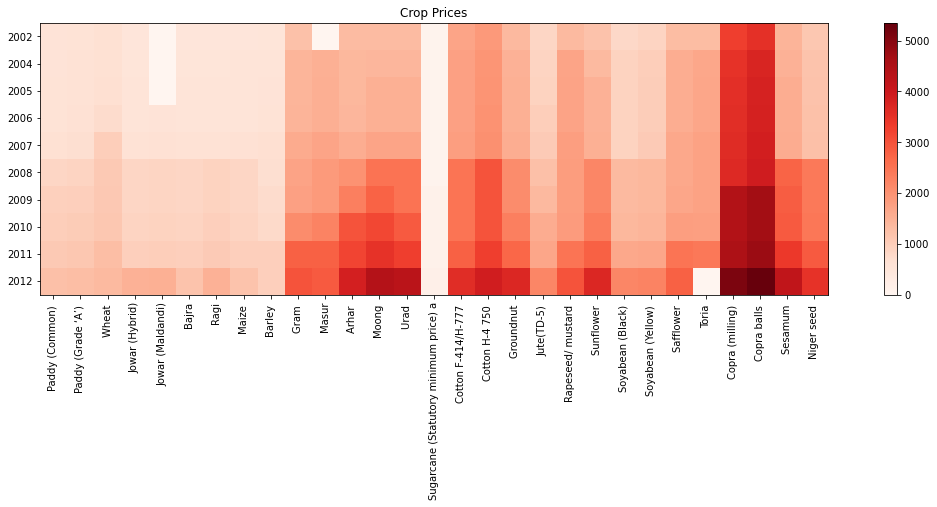

In [8]:
mat1 = np.matrix(crop_price.values[:,1:],dtype='float')
fig = plt.figure(num=2,figsize=(20,5))
ax = fig.add_subplot(1,1,1)
plt.imshow(mat1.T, cmap='Reds')
ax.set_yticks(np.arange(len(crop_price.columns[1:])))
ax.set_xticks(np.arange(len(crop_price.iloc[:,0])))
ax.set_yticklabels(crop_price.columns[1:])
ax.set_xticklabels(crop_price.iloc[:,0],rotation='vertical')
plt.colorbar()
plt.title('Crop Prices')
plt.show()

#### Área bajo datos de cultivo

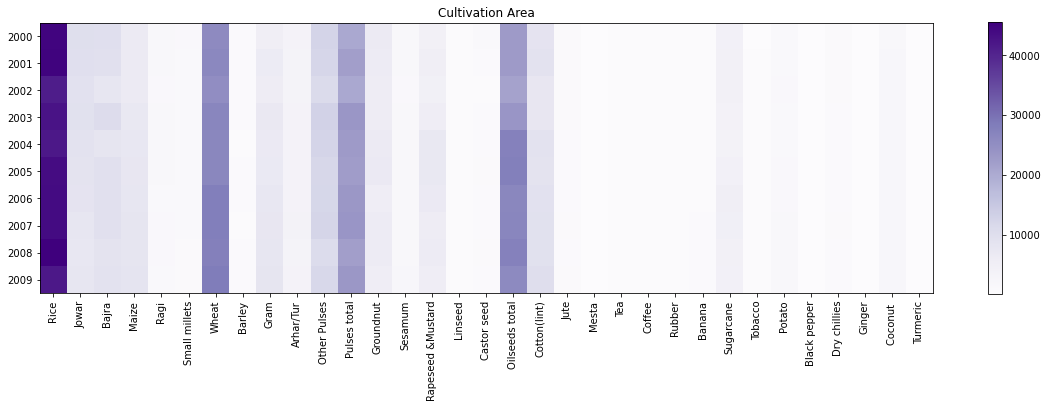

In [9]:
mat2 = np.matrix(area_cult.values[:,1:],dtype='float')
# print(mat2.shape)
mat2=np.delete(mat2,12,1)
# print(mat2.shape)
fig = plt.figure(num=3,figsize=(20,5))
ax = fig.add_subplot(1,1,1)
# ax.set_aspect('equal')
ax.set_xticks(np.arange(len(np.delete(area_cult.columns[1:],12))))
ax.set_yticks(np.arange(len(area_cult.iloc[:,0])))
ax.set_xticklabels(np.delete(area_cult.columns[1:],12),rotation='vertical')
ax.set_yticklabels(area_cult.iloc[:,0])
plt.imshow(mat2, cmap='Purples')
plt.colorbar()
plt.title('Cultivation Area')
plt.show()

#### Costo de cultivo de los principales cultivos (A2 + FL y c2):

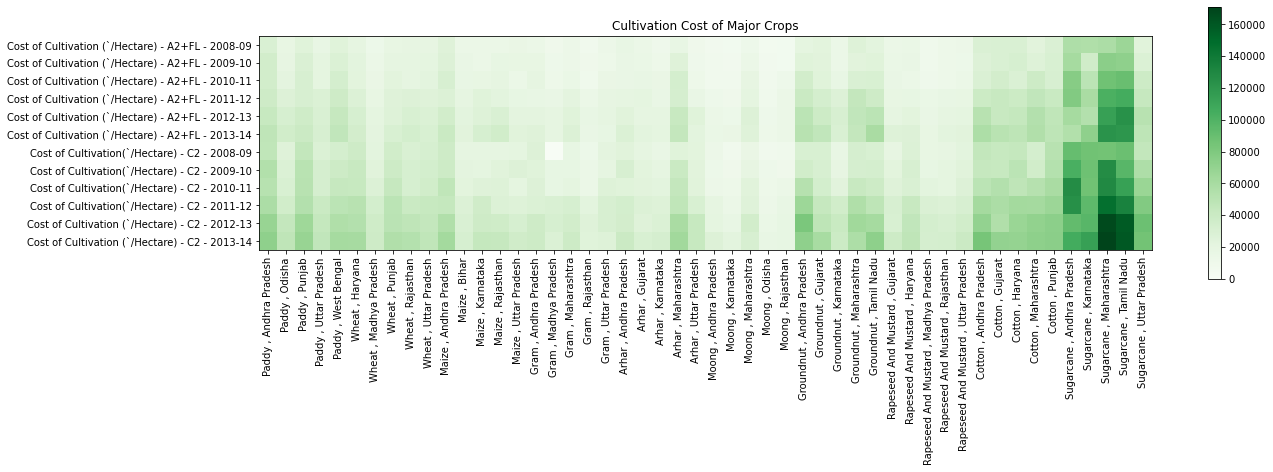

In [10]:
mat3 = np.matrix(culti_cost.values[:,2:14],dtype='float').T
fig = plt.figure(num=3,figsize=(20,5))
ax = fig.add_subplot(1,1,1)
# ax.set_aspect('equal')
ax.set_yticks(np.arange(len(culti_cost.columns[2:14])))
ax.set_xticks(np.arange(len(culti_cost.values[:,0]+' , '+culti_cost.values[:,1])))
ax.set_yticklabels(culti_cost.columns[2:14])
ax.set_xticklabels(culti_cost.values[:,0]+' , '+culti_cost.values[:,1],rotation='vertical')
plt.imshow(mat3, cmap='Greens')
plt.colorbar()
plt.title('Cultivation Cost of Major Crops')
plt.show()

#### Costo de cultivo de los principales cultivos por quintal en ese estado:

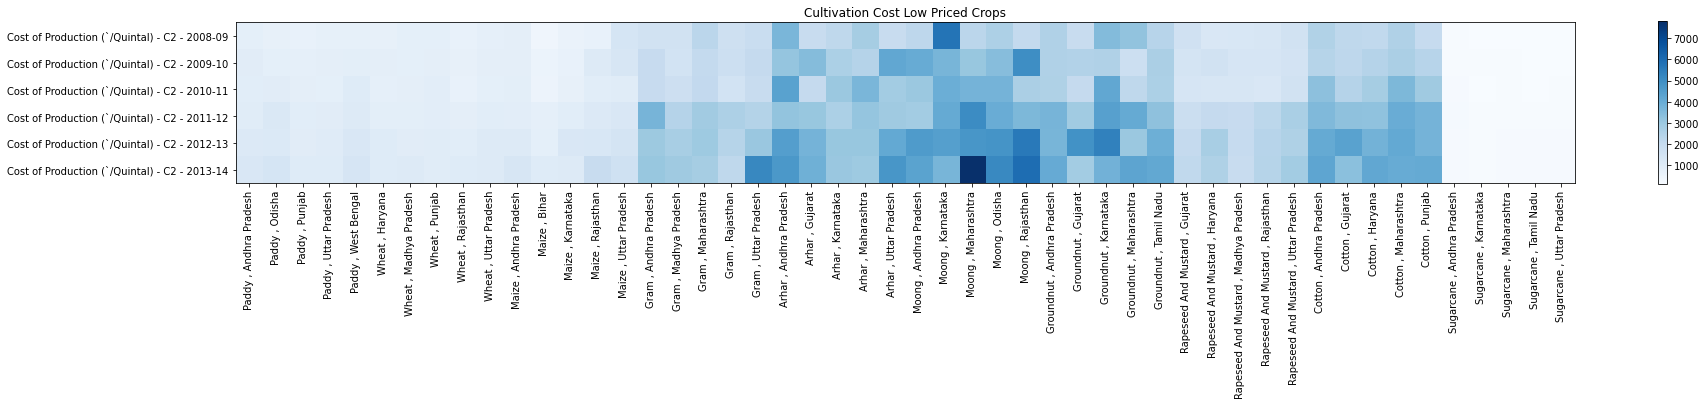

In [11]:
mat4 = np.matrix(culti_cost.values[:,14:],dtype='float').T
fig = plt.figure(num=4,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
# ax.set_aspect('equal')
ax.set_yticks(np.arange(len(culti_cost.columns[14:])))
ax.set_xticks(np.arange(len(culti_cost.values[:,0]+' , '+culti_cost.values[:,1])))
ax.set_yticklabels(culti_cost.columns[14:])
ax.set_xticklabels(culti_cost.values[:,0]+' , '+culti_cost.values[:,1],rotation='vertical')
plt.imshow(mat4, cmap='Blues')
plt.colorbar()
plt.title('Cultivation Cost Low Priced Crops')
plt.show()

#### 5. Lectura de las temperaturas medias a lo largo de los años de la base de datos

In [12]:
temperature = pd.read_csv('Mean_Temperatures.csv',delimiter=',')
temperature.head()

,YEAR,ANNUAL,JAN-FEB,MAR-MAY,JUN-SEP,OCT-DEC
0,2000,24.60,19.33,26.47,27.23,22.68
1,2001,24.73,19.75,26.82,27.47,22.52
2,2002,25.00,19.65,27.22,27.71,22.58
3,2003,24.72,19.82,26.52,27.64,22.23
4,2004,24.74,19.93,27.06,27.33,22.24


#### Visualización de datos de temperatura media a lo largo de los años

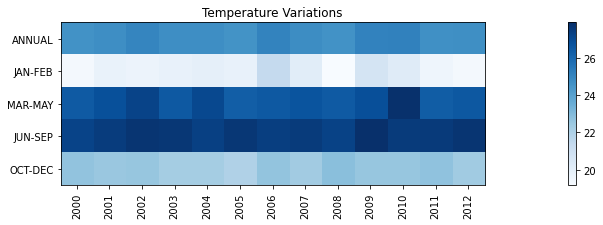

In [13]:
mat5 = np.matrix(temperature.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(temperature.columns[1:])))
ax.set_xticks(np.arange(len(temperature.values[:,0])))
ax.set_yticklabels(temperature.columns[1:])
ax.set_xticklabels(temperature.values[:,0].astype(int),rotation='vertical')
plt.imshow(mat5, cmap='Blues')
plt.colorbar()
plt.title('Temperature Variations')
plt.show()

#### 6. Leer los datos de las precipitaciones anuales en diferentes estados

In [14]:
rainfall =  pd.read_csv('rainfall_cleaned.csv',delimiter=',')
rainfall.head()

,STATES,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL
0,ANDAMAN & NICOBAR ISLANDS,2000,53.0,59.0,171.3,218.1,422.8,357.0,176.3,460.8,250.1,321.2,158.3,115.2,2763.2
1,ANDAMAN & NICOBAR ISLANDS,2001,89.0,15.7,143.3,30.1,705.3,370.7,341.3,469.0,334.4,267.6,222.6,91.8,3080.9
2,ANDAMAN & NICOBAR ISLANDS,2002,10.6,0.0,11.5,100.2,366.7,358.3,317.4,429.8,420.0,169.0,306.7,129.9,2620.2
3,ANDAMAN & NICOBAR ISLANDS,2003,44.3,7.9,149.2,19.4,296.3,159.9,494.9,379.4,371.9,310.4,74.1,48.0,2355.9
4,ANDAMAN & NICOBAR ISLANDS,2004,54.5,35.9,36.5,41.6,505.1,423.9,378.9,308.7,280.7,223.9,169.9,0.4,2460.1


#### Modificación de datos para observación

In [15]:
rainfall1=rainfall.copy()
rainfall1 = rainfall1.groupby(['STATES','YEAR'],as_index=True).mean()
# rainfall1.iloc[:,12].unstack(level=-1).reset_index().head()

#### Visualización de datos de lluvia anual a lo largo de los años

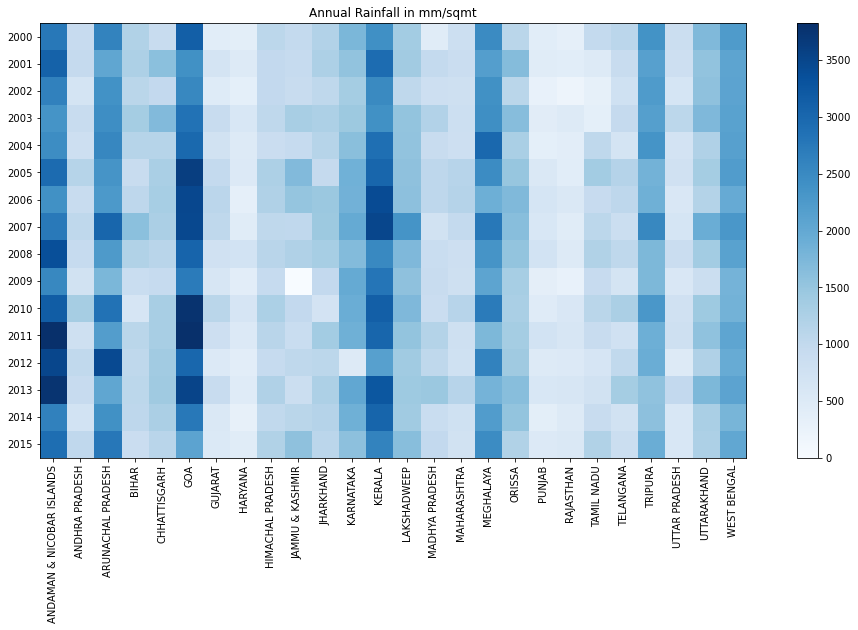

In [16]:
mat6 = np.matrix(rainfall1.iloc[:,12].unstack(level=-1).reset_index().values[:,1:],dtype='float').T
fig = plt.figure(num=6,figsize=(18,8))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(rainfall1.iloc[:,12].unstack(level=-1).reset_index().columns[1:])))
ax.set_xticks(np.arange(len(rainfall1.iloc[:,12].unstack(level=-1).reset_index().values[:,0])))
ax.set_yticklabels(rainfall1.iloc[:,12].unstack(level=-1).reset_index().columns[1:])
ax.set_xticklabels(rainfall1.iloc[:,12].unstack(level=-1).reset_index().values[:,0],rotation='vertical')
plt.imshow(mat6, cmap='Blues')
plt.colorbar()
plt.title('Annual Rainfall in mm/sqmt')
plt.show()

#### 7. Lectura de datos para la tasa de crecimiento de los principales cultivos a lo largo de los años

In [17]:
growth = pd.read_csv('Avg annual Growth Rate_Major Crops.csv',delimiter = ',')
growth = pd.concat([growth.iloc[:,0],growth.iloc[:,5:]],axis=1,sort=False)
growth = growth.dropna()
growth.head()

,Crop,(Ninth Plan) 1997-98 to 2001-02,(Tenth Plan) 2002-03 to 2006-07,(Eleventh Plan) 2007-08 to 2011-12
0,Wheat,0.7,-0.3,3.0
1,Rice,2.1,1.2,2.2
2,Jowar,0.2,2.1,3.1
3,Bajra,4.9,7.3,8.4
4,Maize,3.1,-0.2,6.5


#### Visualización de datos de tasa de crecimiento

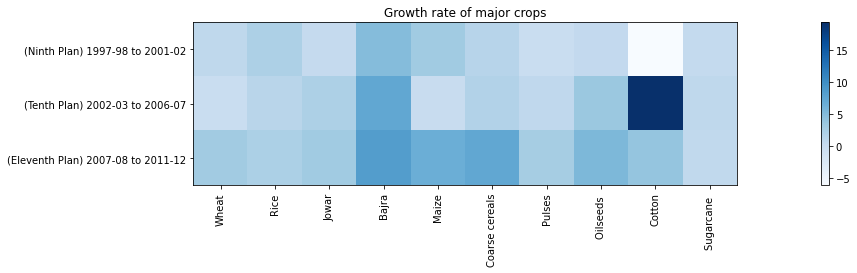

In [18]:
mat7 = np.matrix(growth.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(growth.columns[1:])))
ax.set_xticks(np.arange(len(growth.values[:,0])))
ax.set_yticklabels(growth.columns[1:])
ax.set_xticklabels(growth.values[:,0],rotation='vertical')
plt.imshow(mat7, cmap='Blues')
plt.colorbar()
plt.title('Growth rate of major crops')
plt.show()

#### 8. Lectura de la base de datos del número de suicidios en varios estados a lo largo de los años.

In [19]:
suicides = pd.read_csv('suicides_10-14.csv',delimiter = ',')
suicides.drop(columns={'Sl. No.','2014 - Labourers'},inplace=True)
suicides.iloc[:,:].fillna(0,inplace=True)
suicides.head()

,State/UT,2010,2011,2012,2013,2014
0,ANDHRA PRADESH,2525.0,2206.0,2572.0,2014.0,160
1,ARUNACHAL PRADESH,18.0,13.0,11.0,37.0,0
2,ASSAM,369.0,312.0,344.0,305.0,21
3,BIHAR,95.0,83.0,68.0,127.0,0
4,CHHATTISGARH,1126.0,0.0,4.0,0.0,443


#### Visualización del número de datos de suicidios

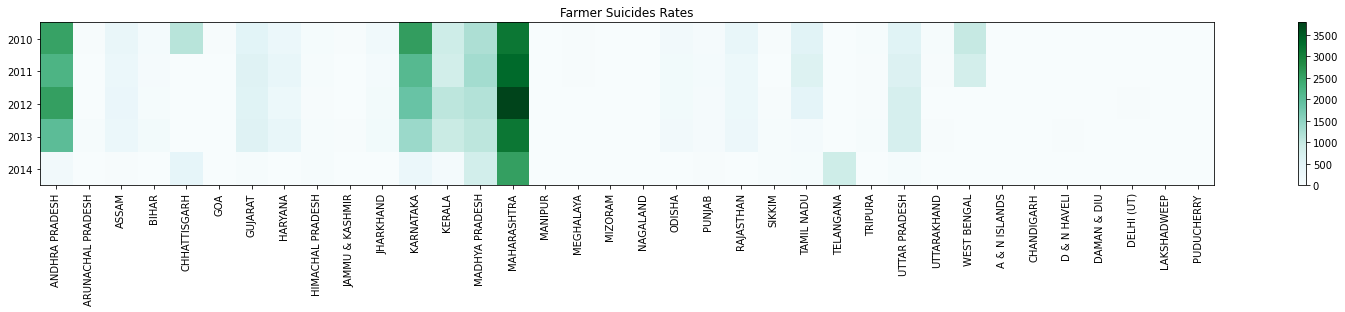

In [20]:
mat8 = np.matrix(suicides.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(suicides.columns[1:])))
ax.set_xticks(np.arange(len(suicides.values[:,0])))
ax.set_yticklabels(suicides.columns[1:])
ax.set_xticklabels(suicides.values[:,0],rotation='vertical')
plt.imshow(mat8, cmap='BuGn')
plt.colorbar()
plt.title('Farmer Suicides Rates')
plt.show()

#### 9. Lectura de datos de exportaciones de varios productos a lo largo de los años

In [21]:
exports = pd.read_csv('IndiaExport.csv',delimiter=',')
to_drop = []
for head in exports.columns[1:]:
    if 'Unn' in head:
        to_drop.append(head)
exports.drop(columns = to_drop,inplace=True)
exports = exports.drop(0)
exports.rename(columns = {'Unnamed: 0':'Product'},inplace = True)
for_plot = exports.copy()
exports = exports.melt(id_vars='Product')
exports.variable = exports.variable.astype(int)
exports.value = exports.value.astype(float)
exports.head()

,Product,variable,value
0,Buffalo Meat,2003,343817.08
1,Basmati Rice,2003,771475.37
2,Rice,2003,2640438.93
3,Guargum,2003,120561.27
4,Wheat,2003,4093080.52


#### Selección de datos relacionados solo con productos agrícolas

In [22]:
plot_exports=for_plot.copy()
plot_exports=plot_exports.reset_index(drop=True)
to_drop=[]
ct=0
for head in plot_exports.Product:
    if 'Meat' in head:
        to_drop.append(head)
        plot_exports.drop(ct,inplace=True)
    ct+=1
plot_exports.drop([9,15,23,26,29,32],inplace=True)
plot_exports = plot_exports.reset_index(drop=True)
plot_exports.Product[plot_exports.Product=='Cucumber and Gherkins( Prepd. & Presvd)'] = 'Cucumber and Gherkins'
plot_exports.head()

,Product,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,Basmati Rice,771475.37,1162989.16,1166562.79,1045714.95,1183355.73,1556411.06,2016775,2370658.39,3178174.43,3459898.93,3757271.42,3702260.07
1,Rice,2640438.93,3615109.55,2921601.91,3702191.99,5285916.33,931879.8,139540.76,100685.78,3997719.57,6687990.85,7133183.37,8274046.02
2,Guargum,120561.27,131299.98,186718.4,189304.36,211166.56,258567.56,218479.74,441607.7,707326.43,406311.81,601945.42,665177.71
3,Wheat,4093080.52,2009343.03,746173.23,46633.21,237.27,1120.52,47.3,394.47,740746.76,6514810.6,5562374.74,2924070.18
4,Groundnuts,176109.32,177154.08,190053.34,251428.65,269587.64,297890.37,340246.31,433753.23,832616.93,535637.36,509664.84,708386.26


#### Visualización de exportaciones de productos agrícolas

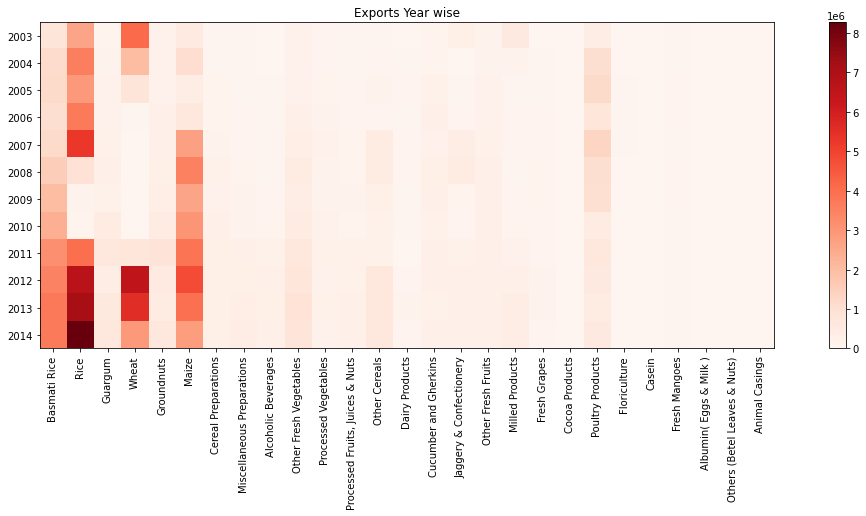

In [23]:
mat8 = np.matrix(plot_exports.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(20,6))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(plot_exports.columns[1:])))
ax.set_xticks(np.arange(len(plot_exports.values[:,0])))
ax.set_yticklabels(plot_exports.columns[1:])
ax.set_xticklabels(plot_exports.values[:,0],rotation='vertical')
plt.imshow(mat8, cmap='Reds')
plt.colorbar()
plt.title('Exports Year wise')
plt.show()

#### Separar los datos del área de la tabla de datos principal

In [24]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
area.drop(columns={'Production'},inplace=True)
area = area.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
area.head()

,State_Name,Crop_Year,Crop,Area
0,Andaman and Nicobar Islands,2000,Arecanut,4354.0
1,Andaman and Nicobar Islands,2000,Other Kharif pulses,670.0
2,Andaman and Nicobar Islands,2000,Rice,10881.0
3,Andaman and Nicobar Islands,2000,Banana,1707.0
4,Andaman and Nicobar Islands,2000,Cashewnut,800.0


#### Separar los datos de producción de la tabla de datos principal

In [25]:
production = pd.concat([crop_prod.iloc[:,0:5],crop_prod.iloc[:,6:7]],axis=1)
production = production.loc[production.loc[:,'Crop_Year'] >=2000,:]
# production.drop(columns={'Production'},inplace=True)
production = production.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
production.Crop[production.Crop == 'Paddy'] = 'Rice'
production.Crop[production.Crop == 'Moong(Green Gram)'] = 'Moong'
production.head()

,State_Name,Crop_Year,Crop,Production
0,Andaman and Nicobar Islands,2000,Arecanut,7200.0
1,Andaman and Nicobar Islands,2000,Other Kharif pulses,449.0
2,Andaman and Nicobar Islands,2000,Rice,32184.0
3,Andaman and Nicobar Islands,2000,Banana,12714.0
4,Andaman and Nicobar Islands,2000,Cashewnut,219.0


#### Conversión de nombres en la forma requerida tanto en la tabla de precios de área como de cultivo

In [26]:
area.Crop[area.Crop == 'Paddy'] = 'Rice'
area.Crop[area.Crop == 'Moong(Green Gram)'] = 'Moong'
list_area=sort(area.Crop.unique())
list_price=sort(crop_price.Commodities.unique())
for item in list_price:
    if 'Paddy' in item:
        crop_price.Commodities[crop_price.Commodities == item]='Rice'
for item in list_price:
    for item_area in list_area:
        if item.strip() in item_area or item_area.strip() in item:
            if item != item_area:
                crop_price.Commodities[crop_price.Commodities == item]=item_area
crop_price.Commodities[crop_price.Commodities == 'Cotton F-414/H-777 ']='Cotton(lint)'
crop_price.Commodities[crop_price.Commodities == 'Cotton H-4 750 ']='Cotton(lint)'
crop_price.Commodities[crop_price.Commodities == 'Paddy']='Rice'
crop_price = crop_price.groupby(['Commodities'],as_index=False,sort=False).sum()
# crop_price.head()

In [27]:
# Converting data to make it visualizable
area_price=area.iloc[:,1:]
area_price = area_price.groupby(['Crop_Year','Crop'],as_index=True,sort=False).sum()
area_price = area_price.iloc[:,:].unstack(level=0).reset_index()
area_price = area_price.fillna(0)
area_price.columns = area_price.columns.droplevel()
area_price.rename(columns={'':'Crop'},inplace=True)
area_price = area_price[area_price['Crop'].isin(crop_price.Commodities)].sort_values(by='Crop')
area_price.drop(columns={2000,2001,2003,2013,2014,2015},inplace=True)
area_price.columns = area_price.columns.astype(str)
area_price = area_price.reindex(sorted(area_price.columns), axis=1)
# temp = area_price.iloc[:,1:].reindex_axis(sorted(area_price.iloc[:,1:].columns), axis=1)
# reindex_axis deprecated .. replace with reindex
area_price.head()

Crop_Year,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012,Crop
17,2963889.15,2912104.08,2875328.46,3297134.83,2287957.63,3113224.0,3221594.0,4289565.0,3752892.0,3220916.0,Arhar/Tur
20,7736866.00,9326100.00,9676568.00,9499237.00,8339105.00,8774882.0,8972422.0,9607246.0,3752948.0,3231616.0,Bajra
76,664523.00,602355.57,614672.00,556516.00,604089.00,685198.0,565424.0,677806.0,325548.0,347179.0,Barley
22,7632933.00,8748496.00,8669295.00,9060875.00,6188044.00,9337428.0,9984615.0,10929723.0,11685196.0,9530632.0,Cotton(lint)
23,5892949.47,6636121.22,6819569.26,7625707.57,6348748.22,7818443.0,7274008.0,8862826.0,6335184.0,6544957.0,Gram


In [28]:
# Seleccionar los nombres de los cultivos que están presentes tanto en la tabla area_price como en la tabla crop_price
crop_price = crop_price[crop_price['Commodities'].isin(area_price.Crop)].sort_values(by='Commodities')
crop_price.head()

,Commodities,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012
9,Arhar/Tur,1325.0,1390.0,1400.0,1410.0,1550.0,2000.0,2300.0,3000.0,3200,3850.0
3,Bajra,495.0,515.0,525.0,540.0,600.0,840.0,840.0,880.0,980,1175.0
6,Barley,505.0,540.0,550.0,565.0,650.0,680.0,750.0,780.0,980,980.0
13,Cotton(lint),3590.0,3720.0,3740.0,3760.0,3830.0,5500.0,5500.0,5500.0,6100,7500.0
7,Gram,1225.0,1425.0,1435.0,1445.0,1600.0,1730.0,1760.0,2100.0,2800,3000.0


#### Visualización del área de cultivo para cultivos por año

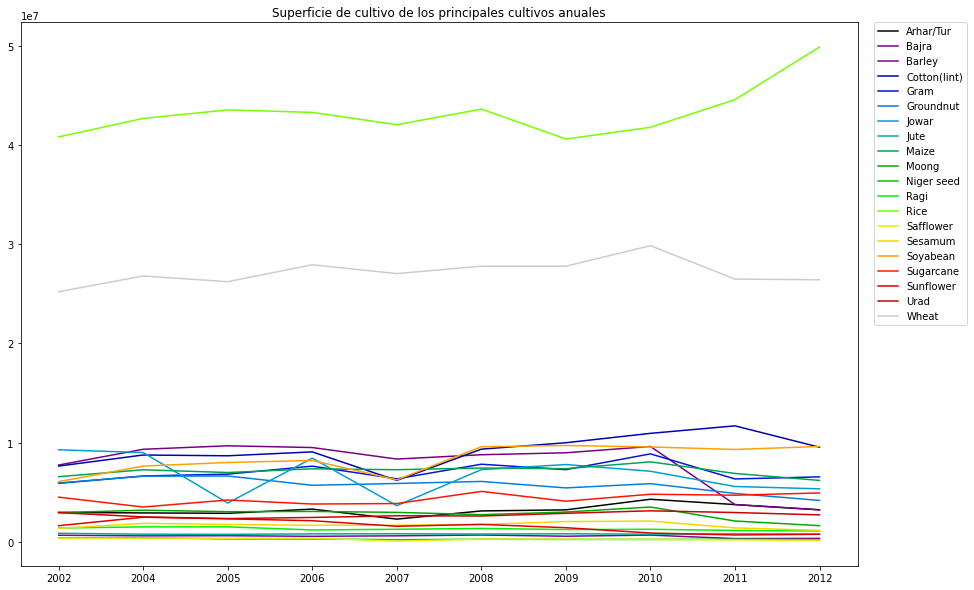

In [29]:
years= area_price.columns[1:]
fig = mplot.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral

# set color cycle pone colores a cada línea
ax1.set_prop_cycle('color', [colormap(i) for i in np.linspace(0, 1,area_price.shape[0])])
for i in range(area_price.shape[0]):
    ax1.plot(area_price.columns[:area_price.shape[1]-1],area_price.iloc[i,:area_price.shape[1]-1])
mplot.legend(area_price.iloc[:,area_price.shape[1]-1],bbox_to_anchor=(1.02,1), borderaxespad=0)
mplot.title('Superficie de cultivo de los principales cultivos anuales')
mplot.show()

# https://stackoverflow.com/questions/44806598/matplotlib-set-color-cycle-versus-set-prop-cycle

#### Visualizing the change in prices of crops year wise

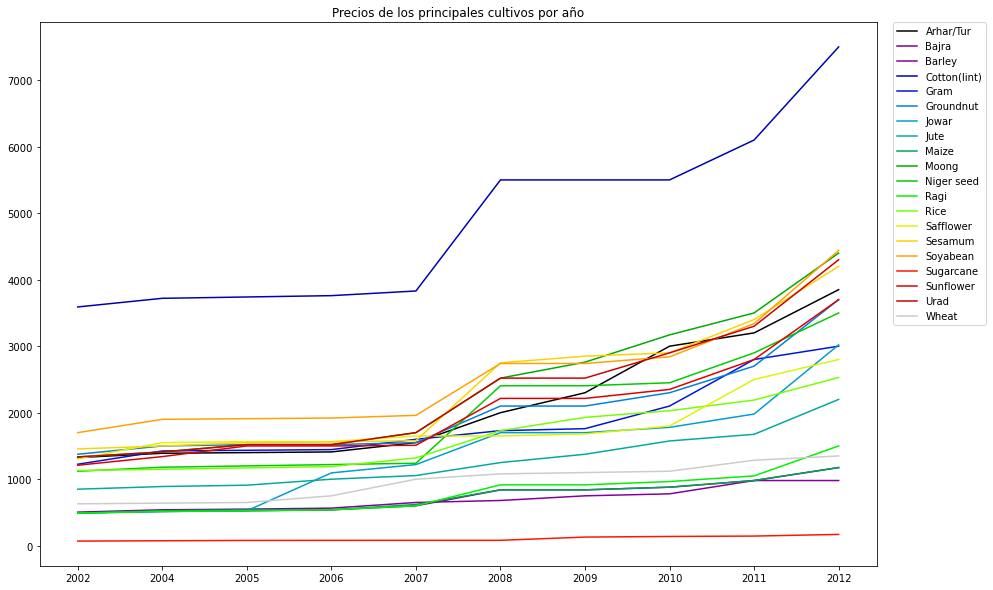

In [30]:
years= crop_price.columns[1:]
fig = mplot.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
ax1.set_prop_cycle('color',[colormap(i) for i in np.linspace(0, 1,crop_price.shape[0])])
for i in range(crop_price.shape[0]):
    ax1.plot(crop_price.columns[1:],crop_price.iloc[i,1:])
mplot.legend(crop_price.iloc[:,0],bbox_to_anchor=(1.02,1), borderaxespad=0)
mplot.title('Precios de los principales cultivos por año')
mplot.show()

#### Conversión de datos de producción para compararlos con datos de precios

In [31]:
production_year=production.iloc[:,1:]
production_year = production_year.groupby(['Crop_Year','Crop'],as_index=True,sort=False).sum()
production_year = production_year.iloc[:,:].unstack(level=0).reset_index()
production_year = production_year.fillna(0)
production_year.columns = production_year.columns.droplevel()
production_year.rename(columns={'':'Crop'},inplace=True)
production_year = production_year[production_year['Crop'].isin(crop_price.Commodities)].sort_values(by='Crop')
production_year.drop(columns={2000,2001,2003,2013,2014,2015},inplace=True)
production_year.columns = production_year.columns.astype(str)
production_year = production_year.reindex(sorted(production_year.columns), axis=1)
production_year.head()

#reindex

Crop_Year,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012,Crop
17,1795828.47,1844665.11,2086762.83,2141779.0,1760907.0,2060437.1,2226782.0,2714289.60,2448644.0,2625573.0,Arhar/Tur
20,4713967.30,8051663.00,7118575.80,8334550.0,8857533.2,8900867.0,6517369.0,12269842.00,6073769.0,4877053.0,Bajra
76,1378805.10,1172234.24,1182183.70,1245089.0,1196276.0,1669726.2,1307238.0,1690447.00,777914.0,817666.0,Barley
22,8561894.20,16974350.00,18388534.50,20890976.0,17294926.0,20777198.0,20898065.0,27317346.00,27366253.0,19767509.0,Cotton(lint)
23,4227669.42,5376640.00,5571145.67,6392945.0,4773122.0,6998378.2,6876010.0,7674255.16,5999415.0,6702250.0,Gram


#### Visualización de la producción de cultivos por año

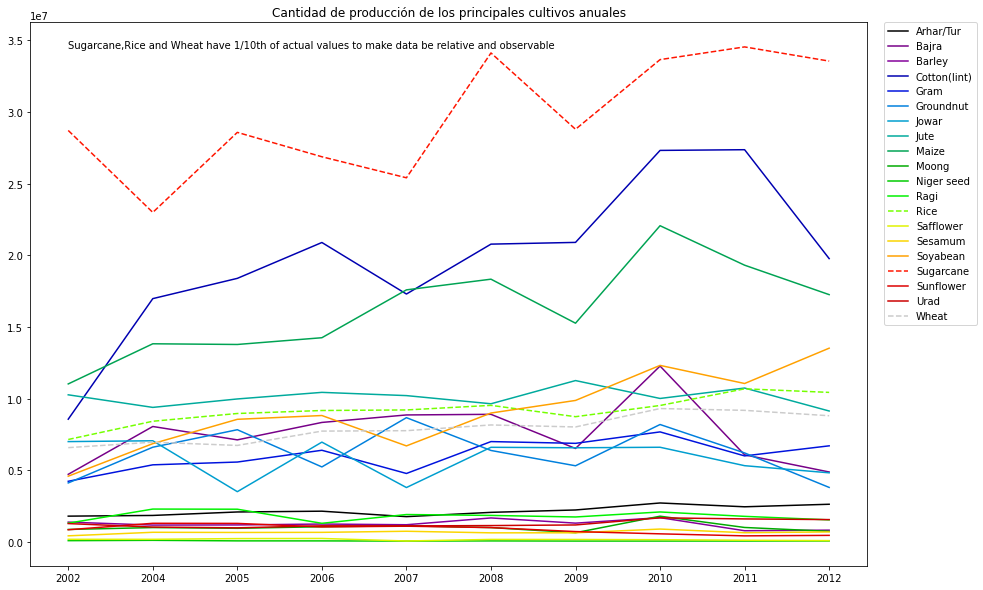

In [32]:
fig = mplot.figure(figsize=(15,10))
t = ("Sugarcane,Rice and Wheat have 1/10th of actual values to make data be relative and observable")
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
ax1.set_prop_cycle('color',[colormap(i) for i in np.linspace(0, 1,production_year.shape[0])])
for i in range(production_year.shape[0]):
    if  production_year.iloc[i,1] < 50000000:
        ax1.plot(production_year.columns[:production_year.shape[1]-1],production_year.iloc[i,:production_year.shape[1]-1])
    else:
        ax1.plot(production_year.columns[:production_year.shape[1]-1],production_year.iloc[i,:production_year.shape[1]-1]/10,linestyle='--')
mplot.legend(production_year.iloc[:,production_year.shape[1]-1],bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.text(0,3.5*10000000, t, ha='left',va='top', rotation=0, wrap=True)
mplot.title('Cantidad de producción de los principales cultivos anuales')
mplot.show()

### Encontrar ganancias por unidad de área para cultivo
ganancia = precio * producción / área

In [33]:
ratio_prod_area = production_year.iloc[:,:area_price.shape[1]-1].reset_index(drop=True)/area_price.iloc[:,:area_price.shape[1]-1].reset_index(drop=True)
ratio_prod_area.index = area_price.index
ratio_prod_area=pd.concat([area_price.iloc[:,area_price.shape[1]-1],ratio_prod_area],axis=1)
# ratio_prod_area.head()
ratio_prod_area_earn = ratio_prod_area.iloc[:,1:].reset_index(drop=True)*crop_price.iloc[:,1:].reset_index(drop=True)
ratio_prod_area_earn.index = area_price.index
ratio_prod_area_earn=pd.concat([area_price.iloc[:,area_price.shape[1]-1],ratio_prod_area_earn],axis=1)
ratio_prod_area_earn.head()

,Crop,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012
17,Arhar/Tur,802.821092,880.492054,1016.046689,915.918986,1192.944229,1323.667748,1589.771585,1898.297100,2087.899359,3138.379284
20,Bajra,301.596772,444.623845,386.216714,473.791421,637.300996,852.060265,610.157431,1123.887216,1586.031466,1773.272962
76,Barley,1047.814110,1050.885094,1057.801616,1264.070188,1287.193443,1657.059443,1733.970436,1945.318661,2341.761338,2308.067827
22,Cotton(lint),4026.918640,7217.764288,7932.954067,8669.148373,10704.443372,12238.336831,11511.646418,13746.496869,14285.951498,15555.769806
23,Gram,878.829025,1154.546722,1172.301905,1211.403065,1202.913541,1548.542886,1663.701442,1818.374392,2651.598122,3072.098105


#### Visualización de posibles ganancias en cultivos principales por unidad de área por año

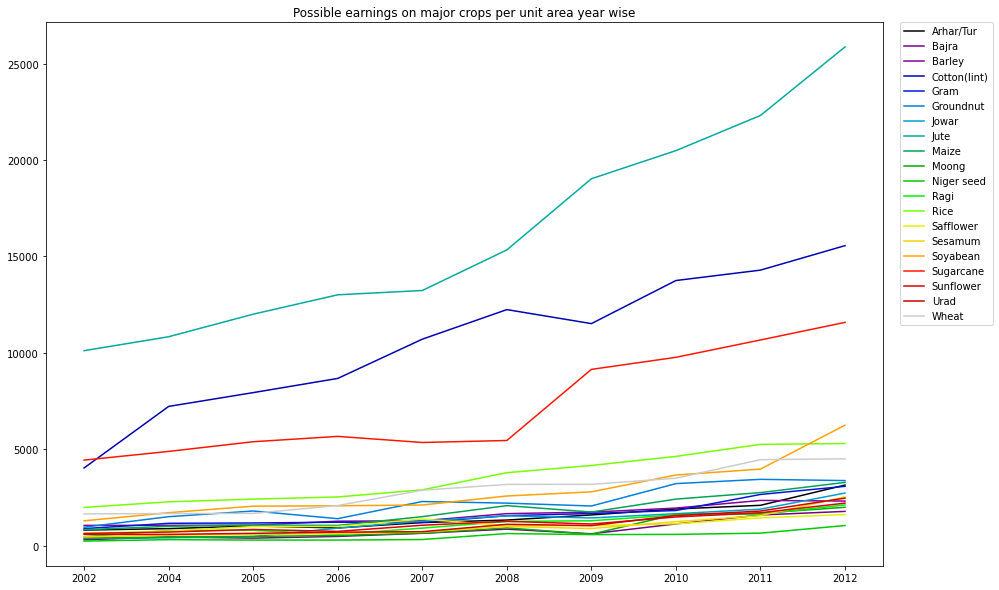

In [34]:
years= ratio_prod_area_earn.columns[1:]
fig = mplot.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
ax1.set_prop_cycle('color',[colormap(i) for i in np.linspace(0, 1,ratio_prod_area_earn.shape[0])])
for i in range(ratio_prod_area_earn.shape[0]):
    ax1.plot(ratio_prod_area_earn.columns[1:],ratio_prod_area_earn.iloc[i,1:])
mplot.legend(ratio_prod_area_earn.iloc[:,0],bbox_to_anchor=(1.02,1), borderaxespad=0)
mplot.title('Possible earnings on major crops per unit area year wise')
mplot.show()

#### Tomando datos para hacer frente a las precipitaciones

In [35]:
prod_rain = crop_prod.copy()
prod_rain = prod_rain.loc[prod_rain.loc[:,'Crop_Year'] >=2000,:]
prod_rain = prod_rain.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
prod_rain.iloc[:,0]=prod_rain.iloc[:,0].str.upper()
prod_rain = prod_rain.drop(columns = {'Crop','Production'})
prod_rain = prod_rain.groupby(['State_Name','Crop_Year'],as_index=False,sort=False).sum()
prod_rain.State_Name[prod_rain.State_Name == 'ANDAMAN AND NICOBAR ISLANDS'] = 'ANDAMAN & NICOBAR ISLANDS'
prod_rain.State_Name[prod_rain.State_Name == 'JAMMU AND KASHMIR '] = 'JAMMU & KASHMIR'
prod_rain.State_Name[prod_rain.State_Name == 'ODISHA'] = 'ORISSA'
prod_rain.State_Name[prod_rain.State_Name == 'TELANGANA '] = 'TELANGANA'
# prod_rain.head()

In [36]:
temp_rain = pd.concat([rainfall.iloc[:,0:2],rainfall.iloc[:,rainfall.shape[1]-1]],axis=1)
prod_rain = prod_rain[prod_rain['State_Name'].isin(temp_rain.STATES)]
temp_rain = temp_rain[temp_rain['STATES'].isin(prod_rain.State_Name)]
temp_rain.head()

,STATES,YEAR,ANNUAL
0,ANDAMAN & NICOBAR ISLANDS,2000,2763.2
1,ANDAMAN & NICOBAR ISLANDS,2001,3080.9
2,ANDAMAN & NICOBAR ISLANDS,2002,2620.2
3,ANDAMAN & NICOBAR ISLANDS,2003,2355.9
4,ANDAMAN & NICOBAR ISLANDS,2004,2460.1


In [37]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
# area.drop(columns={'Production'},inplace=True)
area = area.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
area_temp = area.drop(columns = 'Crop')
area_temp = area_temp.groupby(['State_Name','Crop_Year'],as_index=False,sort=False).sum()
area_temp.iloc[:,0]=area_temp.iloc[:,0].str.upper()
area_temp.State_Name[area_temp.State_Name == 'ANDAMAN AND NICOBAR ISLANDS'] = 'ANDAMAN & NICOBAR ISLANDS'
area_temp.State_Name[area_temp.State_Name == 'JAMMU AND KASHMIR '] = 'JAMMU & KASHMIR'
area_temp.State_Name[area_temp.State_Name == 'ODISHA'] = 'ORISSA'
area_temp.State_Name[area_temp.State_Name == 'TELANGANA '] = 'TELANGANA'
# area_temp.shape,temp_rain.shape
area_temp = area_temp[area_temp['State_Name'].isin(temp_rain.STATES)]
temp_rain = temp_rain[temp_rain['STATES'].isin(area_temp.State_Name)]
area_temp.head()
# ratio_prod_rain = pd.concat([prod_rain.iloc[:,0:3],prod_rain.Area*temp_rain.ANNUAL],axis=1)
# ratio_prod_rain

,State_Name,Crop_Year,Area,Production
0,ANDAMAN & NICOBAR ISLANDS,2000,44518.00,89060914.00
1,ANDAMAN & NICOBAR ISLANDS,2001,41163.00,89718700.00
2,ANDAMAN & NICOBAR ISLANDS,2002,45231.40,94387137.67
3,ANDAMAN & NICOBAR ISLANDS,2003,44799.40,95296454.67
4,ANDAMAN & NICOBAR ISLANDS,2004,45308.77,87186497.63


In [38]:
area_rainfall = pd.merge(area_temp.rename(columns={"State_Name": "STATES", "Crop_Year": "YEAR"}),temp_rain,how='inner')
area_rainfall.head()

,STATES,YEAR,Area,Production,ANNUAL
0,ANDAMAN & NICOBAR ISLANDS,2000,44518.00,89060914.00,2763.2
1,ANDAMAN & NICOBAR ISLANDS,2001,41163.00,89718700.00,3080.9
2,ANDAMAN & NICOBAR ISLANDS,2002,45231.40,94387137.67,2620.2
3,ANDAMAN & NICOBAR ISLANDS,2003,44799.40,95296454.67,2355.9
4,ANDAMAN & NICOBAR ISLANDS,2004,45308.77,87186497.63,2460.1


In [39]:
# area_rainfall.Area = area_rainfall.Production/(area_rainfall.Area*area_rainfall.ANNUAL)
# area_rainfall.head()

In [40]:
suicides.head()
suicides.rename(columns={'State/UT':'STATES'},inplace = True)

In [41]:
area_rainfall_plot = area_rainfall[area_rainfall['STATES'].isin(suicides.STATES)]
area_rainfall_plot.dropna()
suicides = suicides[suicides['STATES'].isin(area_rainfall_plot.STATES)]
area_rainfall_plot.shape

(312, 5)

#### Tomando la proporción de área * precipitación vs producción
- Si este valor es alto, muestra que los agricultores tuvieron pérdidas.

In [42]:
area_rainfall['Calc'] = (area_rainfall.Area*area_rainfall.ANNUAL)/area_rainfall.Production
# area_rainfall

In [43]:
area_rainfall = pd.merge(area_temp.rename(columns={"State_Name": "STATES", "Crop_Year": "YEAR"}),temp_rain,how='inner')
area_rain_no0=area_rainfall.copy()
# area_rain_no0.iloc[:,2:] = fill_0(area_rain_n0.iloc[:,2:])
area_rain_no0.head()

,STATES,YEAR,Area,Production,ANNUAL
0,ANDAMAN & NICOBAR ISLANDS,2000,44518.00,89060914.00,2763.2
1,ANDAMAN & NICOBAR ISLANDS,2001,41163.00,89718700.00,3080.9
2,ANDAMAN & NICOBAR ISLANDS,2002,45231.40,94387137.67,2620.2
3,ANDAMAN & NICOBAR ISLANDS,2003,44799.40,95296454.67,2355.9
4,ANDAMAN & NICOBAR ISLANDS,2004,45308.77,87186497.63,2460.1


#### Estados de búsqueda que se ven afectados por la precipitación promedio anual por área (es decir, área frente a precipitación)
- Esto significa cuáles de los estados dependen en gran medida de las precipitaciones para el área de cultivo.

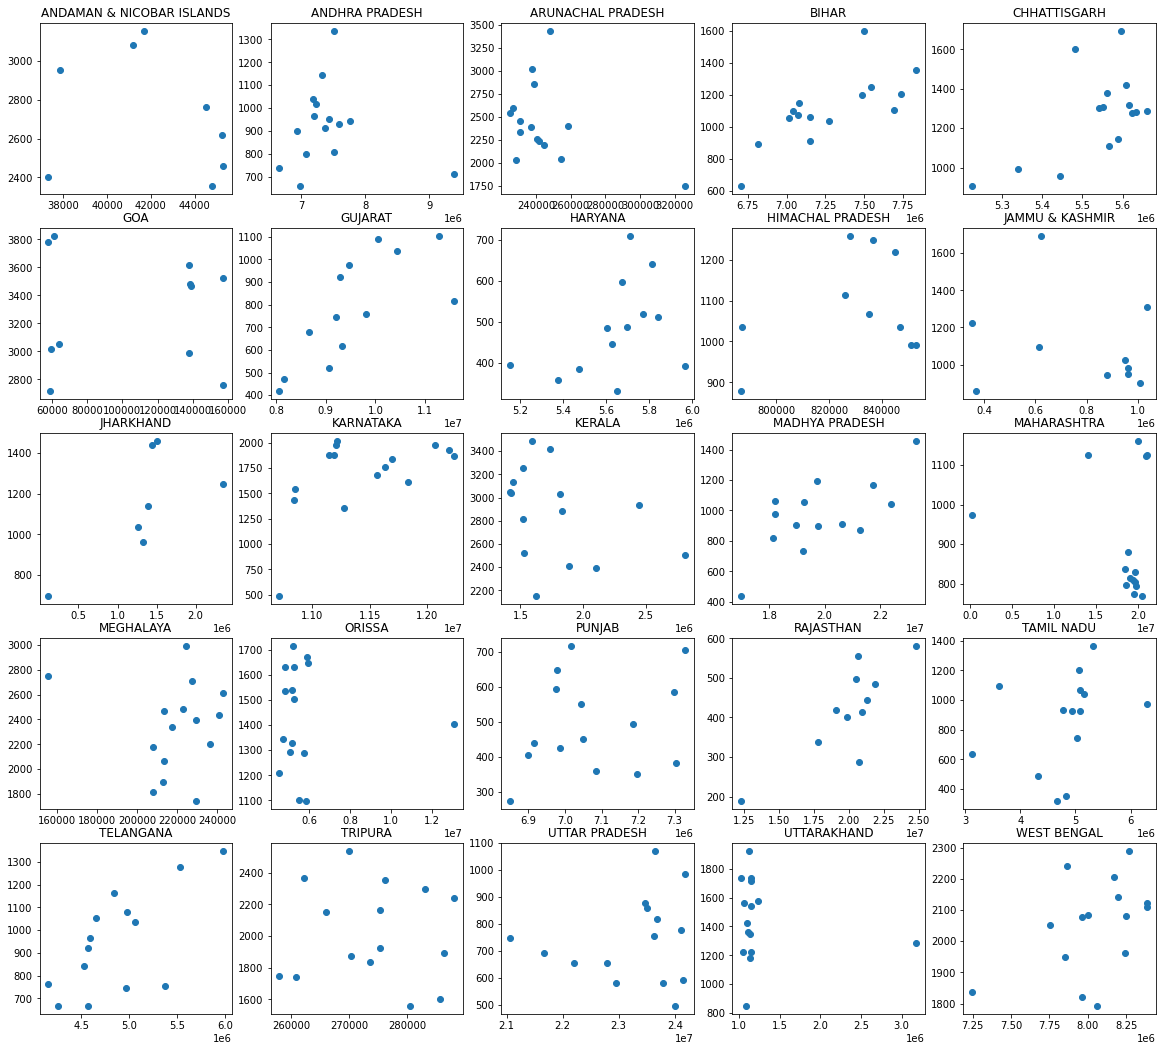

In [44]:
ct = 1
fig = mplot.figure(figsize=(20,22))
for i in area_rain_no0.STATES.unique():
    tp= area_rain_no0[area_rain_no0.STATES==i]
    tp=tp.iloc[:,2:] 
    mplot.subplot(6,5,ct)
    mplot.scatter(tp.iloc[:,0],tp.iloc[:,2])
    mplot.title(i)
    ct+=1
mplot.show()

#### Encontrar estados que se ven afectados por la precipitación media anual para la producción (i.n. Producción y lluvia): 
- esto significa qué estados se ven afectados por la lluvia para la producción

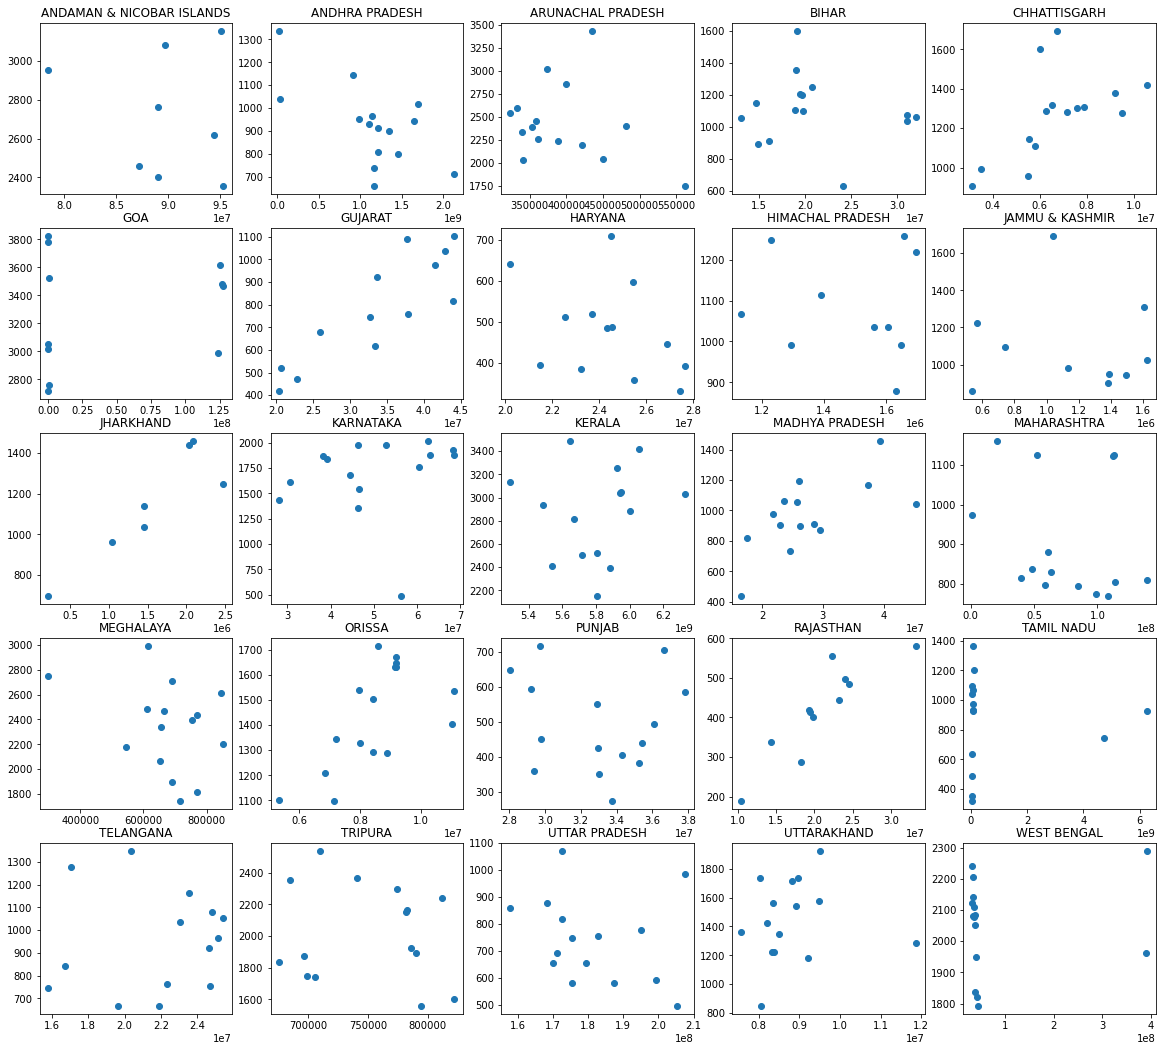

In [45]:
ct = 0
fig = mplot.figure(figsize=(20,22))
for i in area_rain_no0.STATES.unique():
    tp= area_rain_no0[area_rain_no0.STATES==i]
    tp=tp.iloc[:,2:]
    ct+=1
    mplot.subplot(6,5,ct)
    mplot.scatter(tp.iloc[:,1],tp.iloc[:,2])
    mplot.title(i)
mplot.show()

#### Encontrar estados que se ven afectados por la precipitación promedio anual por proporción de producción y área (es decir, producción / área vs precipitación)
- Esto significa en qué estados la proporción de productos y área cultivada se ve afectada por las lluvias.

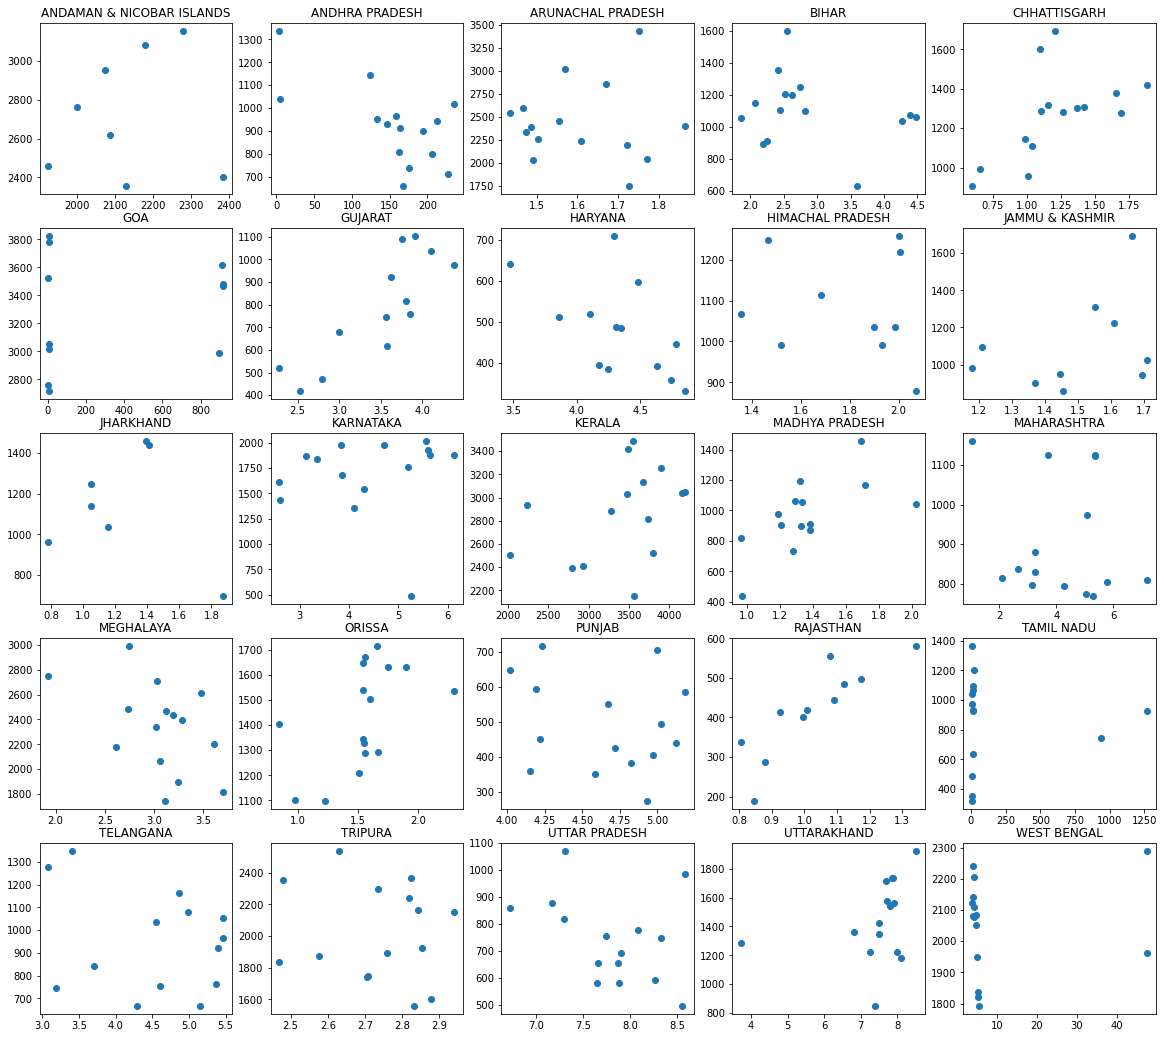

In [46]:
ct = 0
fig = mplot.figure(figsize=(20,22))
for i in area_rain_no0.STATES.unique():
    tp= area_rain_no0[area_rain_no0.STATES==i]
    tp=tp.iloc[:,2:]
    ct+=1
    mplot.subplot(6,5,ct)
    mplot.scatter(tp.iloc[:,1]/tp.iloc[:,0],tp.iloc[:,2])
    mplot.title(i)
mplot.show()

## Convertir todos los datos para fusionarlos en una tabla y luego guardarlos en un archivo csv

In [47]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
# area.drop(columns={'Production'},inplace=True)
area = area.groupby(['Crop_Year','Crop'],as_index=False,sort=False).sum()
# area_temp = area.drop(columns = 'Crop')
# area_temp = area_temp.groupby(['State_Name','Crop_Year'],as_index=False,sort=False).sum()
area_temp=area.copy()
# area_temp.shape,temp_rain.shape
# area_temp.head()

In [48]:
area_heat =pd.merge(area_temp.rename(columns={"Crop_Year": "YEAR"}),temperature.iloc[:,0:2],how='inner',sort=False)
area_heat['Ratio'] = area_heat.Production/area_heat.Area
# area_heat.head()

In [49]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
# area.drop(columns={'Production'},inplace=True)
area = area.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
area_temp=area.copy()
area_temp.iloc[:,0]=area_temp.iloc[:,0].str.upper()
area_temp.State_Name[area_temp.State_Name == 'ANDAMAN AND NICOBAR ISLANDS'] = 'ANDAMAN & NICOBAR ISLANDS'
area_temp.State_Name[area_temp.State_Name == 'JAMMU AND KASHMIR '] = 'JAMMU & KASHMIR'
area_temp.State_Name[area_temp.State_Name == 'ODISHA'] = 'ORISSA'
area_temp.State_Name[area_temp.State_Name == 'TELANGANA '] = 'TELANGANA'
area_temp.Crop[area_temp.Crop=='Paddy'] = 'Rice' 
area_temp.Crop[area_temp.Crop == 'Moong(Green Gram)'] = 'Moong'

In [50]:
temp_crop_price = crop_price.melt(id_vars=['Commodities'])
temp_crop_price.variable=temp_crop_price.variable.astype(int)

In [51]:
temp_cost = pd.concat([culti_cost.iloc[:,0:2],culti_cost.iloc[:,8:14]],axis=1)
years = temp_cost.columns[2:]
temp_cost.columns = list(temp_cost.columns[:2])+list([year[len(year)-7:len(year)-3] for year in years ])
temp_cost= temp_cost.melt(id_vars=['Crop','State/ UT Name'])
temp_cost.Crop[temp_cost.Crop=='Paddy'] = 'Rice'
temp_cost.Crop[temp_cost.Crop=='Arhar'] = 'Arhar/Tur'
temp_cost.Crop[temp_cost.Crop=='Cotton'] = 'Cotton(lint)'
temp_cost.Crop[temp_cost.Crop=='Rapeseed And Mustard'] = 'Rapeseed'
temp_cost.rename(columns={'State/ UT Name':'STATES'},inplace=True)
temp_cost.STATES = temp_cost.STATES.str.upper()
temp_cost.STATES[temp_cost.STATES=='ODISHA']='ORISSA'
temp_cost.variable = temp_cost.variable.astype(int)

In [52]:
temp_cost1 = pd.concat([culti_cost.iloc[:,0:2],culti_cost.iloc[:,14:19]],axis=1)
years = temp_cost1.columns[2:]
temp_cost1.columns = list(temp_cost1.columns[:2])+list([year[len(year)-7:len(year)-3] for year in years ])
temp_cost1= temp_cost1.melt(id_vars=['Crop','State/ UT Name'])
temp_cost1.Crop[temp_cost1.Crop=='Paddy'] = 'Rice'
temp_cost1.Crop[temp_cost1.Crop=='Arhar'] = 'Arhar/Tur'
temp_cost1.Crop[temp_cost1.Crop=='Cotton'] = 'Cotton(lint)'
temp_cost1.Crop[temp_cost1.Crop=='Rapeseed And Mustard'] = 'Rapeseed'
temp_cost1.rename(columns={'State/ UT Name':'STATES'},inplace=True)
temp_cost1.STATES = temp_cost.STATES.str.upper()
temp_cost1.STATES[temp_cost1.STATES=='ODISHA']='ORISSA'
temp_cost1.variable = temp_cost1.variable.astype(int)

In [53]:
temp_sui = suicides.copy()
temp_sui = temp_sui.melt(id_vars='STATES')
temp_sui.variable=temp_sui.variable.astype(int)

### Fusionando todos los datos convertidos arriba

In [54]:
merged_all=pd.merge(area_temp.rename(columns={'State_Name':'STATES','Crop_Year':'YEAR' }),temp_rain.rename(columns={'ANNUAL':'Annual_Rain'}),how='left')
merged_all=pd.merge(merged_all,temperature.iloc[:,0:2].rename(columns={'ANNUAL':'Avg_Temperature'}),how='left')
merged_all=pd.merge(merged_all,temp_crop_price.rename(columns={'Commodities':'Crop','variable':'YEAR','value':'Price'}),how='left')
merged_all=pd.merge(merged_all,temp_cost.rename(columns={'variable':'YEAR','value':'Cost_per_Hectare'}),how='left')
merged_all=pd.merge(merged_all,temp_cost1.rename(columns={'variable':'YEAR','value':'Cost_per_quintal'}),how='left')
merged_all = pd.merge(merged_all,temp_sui.rename(columns={'variable':'YEAR','value':'Suicides'}),how='left')
merged_all = pd.merge(merged_all,exports.rename(columns = {'Product':'Crop','variable':'YEAR','value':'Export'}),how='left')
merged_all.head()

,STATES,YEAR,Crop,Area,Production,Annual_Rain,Avg_Temperature,Price,Cost_per_Hectare,Cost_per_quintal,Suicides,Export
0,ANDAMAN & NICOBAR ISLANDS,2000,Arecanut,4354.0,7200.0,2763.2,24.6,NaN,NaN,NaN,NaN,NaN
1,ANDAMAN & NICOBAR ISLANDS,2000,Other Kharif pulses,670.0,449.0,2763.2,24.6,NaN,NaN,NaN,NaN,NaN
2,ANDAMAN & NICOBAR ISLANDS,2000,Rice,10881.0,32184.0,2763.2,24.6,NaN,NaN,NaN,NaN,NaN
3,ANDAMAN & NICOBAR ISLANDS,2000,Banana,1707.0,12714.0,2763.2,24.6,NaN,NaN,NaN,NaN,NaN
4,ANDAMAN & NICOBAR ISLANDS,2000,Cashewnut,800.0,219.0,2763.2,24.6,NaN,NaN,NaN,NaN,NaN


#### Visualización de la relación entre diferentes características

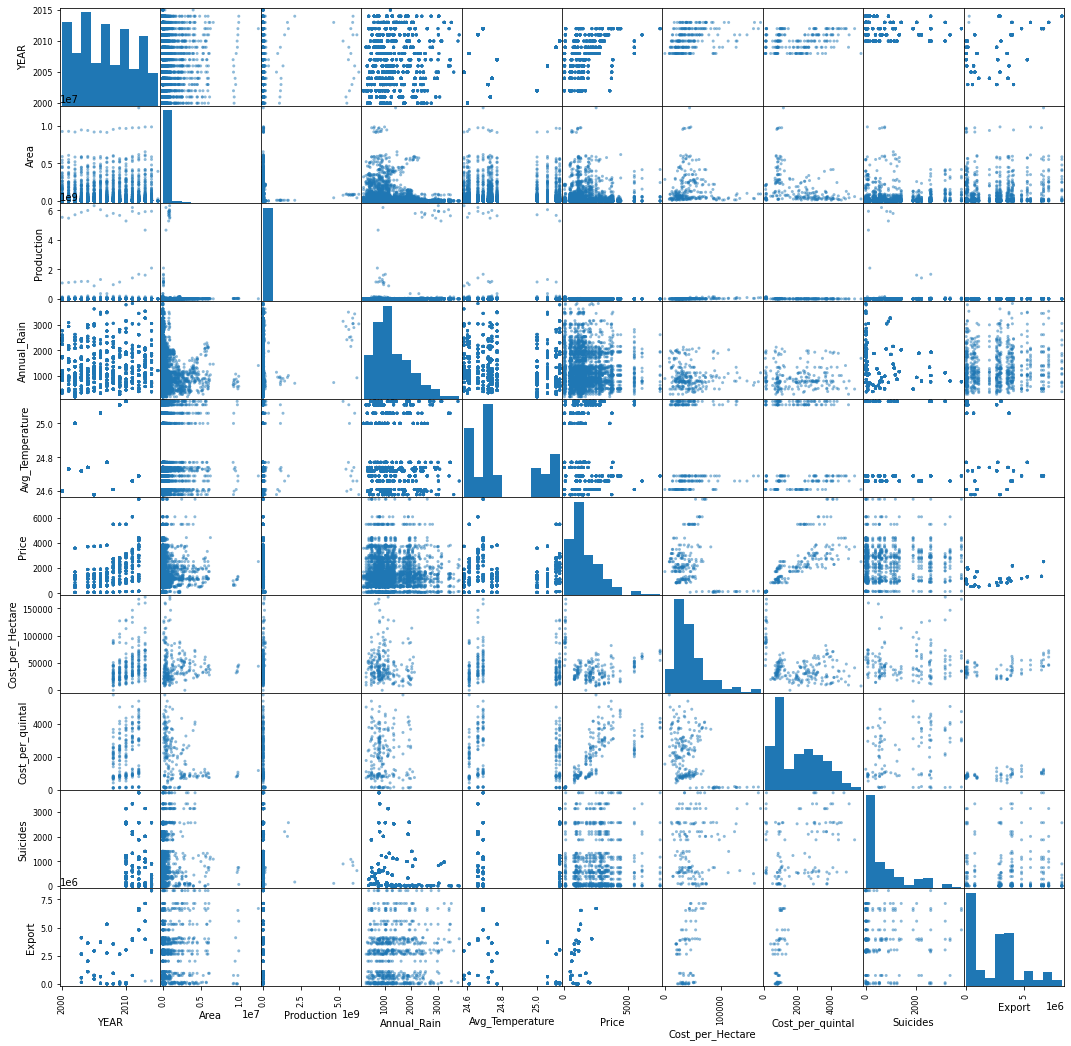

In [55]:
scat_plot = pd.plotting.scatter_matrix(merged_all,alpha=0.5,figsize=(18,18))
mplot.show()

#Actualización pd.scatter_matrix --> pd.plotting.scatter_matrix

In [56]:
merged_all = merged_all.fillna(0)
merged_all.shape

(11314, 12)

In [57]:
merged_all.to_csv('data_set.csv',index=False)

In [58]:
data = pd.read_csv('data_set.csv')
print(data.shape)
data.head()

(11314, 12)


,STATES,YEAR,Crop,Area,Production,Annual_Rain,Avg_Temperature,Price,Cost_per_Hectare,Cost_per_quintal,Suicides,Export
0,ANDAMAN & NICOBAR ISLANDS,2000,Arecanut,4354.0,7200.0,2763.2,24.6,0.0,0.0,0.0,0.0,0.0
1,ANDAMAN & NICOBAR ISLANDS,2000,Other Kharif pulses,670.0,449.0,2763.2,24.6,0.0,0.0,0.0,0.0,0.0
2,ANDAMAN & NICOBAR ISLANDS,2000,Rice,10881.0,32184.0,2763.2,24.6,0.0,0.0,0.0,0.0,0.0
3,ANDAMAN & NICOBAR ISLANDS,2000,Banana,1707.0,12714.0,2763.2,24.6,0.0,0.0,0.0,0.0,0.0
4,ANDAMAN & NICOBAR ISLANDS,2000,Cashewnut,800.0,219.0,2763.2,24.6,0.0,0.0,0.0,0.0,0.0


In [59]:
data_set = data[(data['YEAR'] >=2010)*(data['YEAR'] <=2014) ].fillna(0).groupby(['YEAR','Suicides']).agg('mean').reset_index()
# data_set.head()

### Encontrar correlación entre diferentes características

In [60]:
vals = data_set.corr()
vals

,YEAR,Suicides,Area,Production,Annual_Rain,Avg_Temperature,Price,Cost_per_Hectare,Cost_per_quintal,Export
YEAR,1.000000,-0.072314,0.018936,-0.021838,-0.068967,-0.844673,-0.579313,-0.089484,-0.268659,0.520077
Suicides,-0.072314,1.000000,0.569297,0.053705,-0.153630,0.078271,0.153719,0.629253,0.649622,-0.174800
Area,0.018936,0.569297,1.000000,-0.141455,-0.474405,-0.018899,0.174528,0.611186,0.529003,-0.068576
Production,-0.021838,0.053705,-0.141455,1.000000,0.338707,0.000170,-0.180207,-0.091603,-0.115446,-0.156324
Annual_Rain,-0.068967,-0.153630,-0.474405,0.338707,1.000000,0.011724,-0.221371,-0.394261,-0.348268,0.116749
Avg_Temperature,-0.844673,0.078271,-0.018899,0.000170,0.011724,1.000000,0.820575,0.108782,0.382569,-0.269068
Price,-0.579313,0.153719,0.174528,-0.180207,-0.221371,0.820575,1.000000,0.400618,0.589711,-0.067872
Cost_per_Hectare,-0.089484,0.629253,0.611186,-0.091603,-0.394261,0.108782,0.400618,1.000000,0.735738,0.036654
Cost_per_quintal,-0.268659,0.649622,0.529003,-0.115446,-0.348268,0.382569,0.589711,0.735738,1.000000,-0.096512
Export,0.520077,-0.174800,-0.068576,-0.156324,0.116749,-0.269068,-0.067872,0.036654,-0.096512,1.000000


### Visualización de correlación entre características

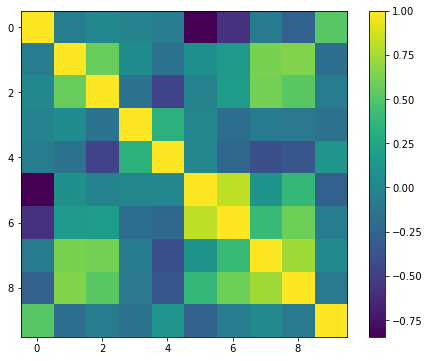

In [61]:
fig=mplot.figure(figsize=(8,6))
mplot.imshow(vals.values)
mplot.colorbar()
mplot.show()

#### Usando regresión lineal para encontrar el modelo de suicidios

In [62]:
model = LR()
X = data_set.drop(columns = ['Suicides','YEAR'],axis=1)
y = data_set['Suicides']
tou = 1
Xx = X.values[y>tou]
Yy = y.values[y>tou]
v1 = Xx.mean(axis = 0)
v2 = Xx.std(axis = 0)
Xx = Xx - v1
Xx = Xx / v2
model.fit(Xx,Yy)
yd = model.predict(Xx)
model.score(Xx,Yy)

0.6207399311406134

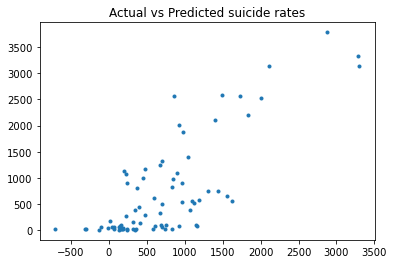

In [63]:
mplot.plot(yd,Yy,'.')
mplot.title('Actual vs Predicted suicide rates')
mplot.show()

#### Uso del método CART para encontrar el modelo de tasas de suicidio

In [64]:
model = scart(max_depth = 4)
model.fit(Xx,Yy)
model.score(Xx,Yy)

0.8387753603502259

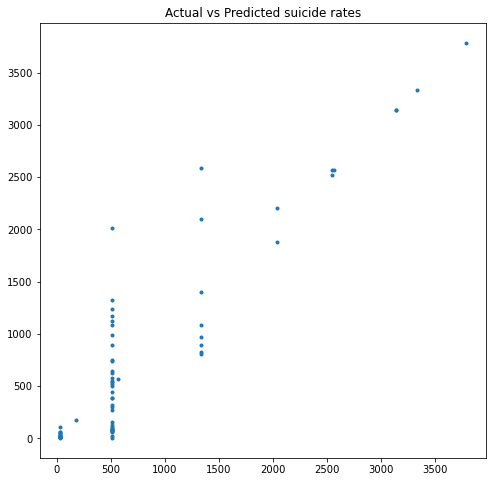

In [65]:
Yd = model.predict(Xx)
fig = mplot.figure(figsize=(8,8))
mplot.plot(Yd,Yy,'.')
mplot.title('Actual vs Predicted suicide rates')
# mplot.savefig('Figures/suicide_pred_cart_model')
mplot.show()

In [66]:
print(model.decision_path(Xx[0:1,:]))

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 5)	1


In [67]:
model.feature_importances_

array([0.67720487, 0.        , 0.08781855, 0.        , 0.        ,
       0.00871357, 0.226263  , 0.        ])

In [68]:
print(model.feature_importances_.argmax())
print(X.columns)

0
Index(['Area', 'Production', 'Annual_Rain', 'Avg_Temperature', 'Price',
       'Cost_per_Hectare', 'Cost_per_quintal', 'Export'],
      dtype='object')


In [69]:
import graphviz #install this library ~ pip install graphviz
from sklearn import tree

In [70]:
dot_data = tree.export_graphviz(model, out_file=None,
                                feature_names=X.columns[:],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data,filename = 'dtree', format = 'png')

In [71]:
#graph.render()

### Dtree modelo
Nota: comentó que esto no funcionaba en otros sistemas. Si necesita verificarlo, puede descomentarlo y verificar si se ejecuta en el sistema.

In [72]:
# graph

In [73]:
data_set = data.fillna(0).groupby(['Crop','YEAR']).agg('mean').reset_index()
dicts = {}
for crop in data_set['Crop'].unique():
    
    X = data_set[data_set['Crop'] == crop]['YEAR'].values.reshape(-1,1)
    Y = data_set[data_set['Crop'] == crop]['Production'].values
    if(X.shape[0] > 5):
        linmodel = LR()
        linmodel.fit(X,Y)
        w = linmodel.coef_[0]
        dicts[crop] = [w]
#         print(w)

#### Encontrar los cultivos que tienen una reducción en la producción a lo largo de los años
- Esto significará qué cultivos se producirán raramente en el futuro.

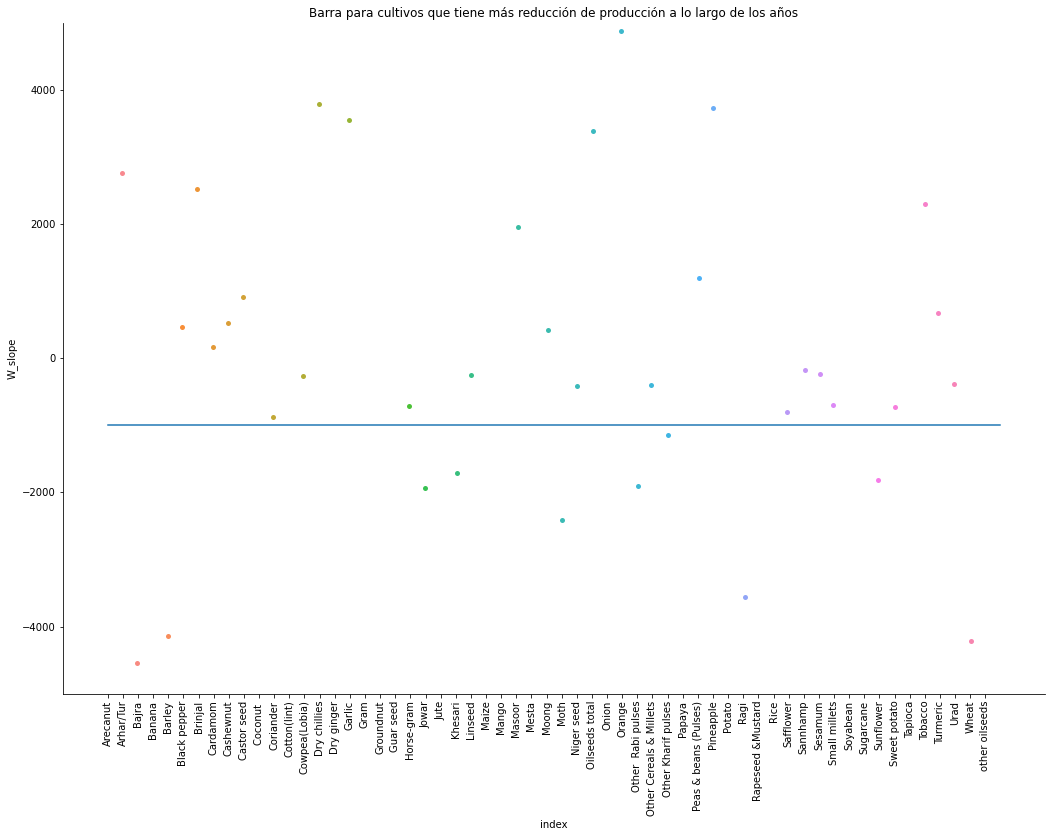

In [74]:
slope_data = pd.DataFrame(dicts).T.reset_index().rename(columns = {0:'W_slope'})
sns.catplot(x='index', y='W_slope', data = slope_data,  height=10, aspect=12/8.27);
plt.ylim(-5000,5000)
plt.xticks(rotation='vertical')
plt.plot([0,slope_data.shape[0]],[-1000,-1000])
plt.title('Barra para cultivos que tiene más reducción de producción a lo largo de los años')
# plt.savefig('Figures/Crops_reduction')
plt.show()

In [75]:
slope_data[slope_data.W_slope<-1000]

,index,W_slope
2,Bajra,-4537.162480
4,Barley,-4141.496114
18,Groundnut,-12034.886469
19,Guar seed,-12780.917262
21,Jowar,-1927.821737
22,Jute,-54720.777614
23,Khesari,-1717.234226
28,Mesta,-5094.770567
30,Moth,-2411.072500
35,Other Rabi pulses,-1908.905869


In [76]:
data_set = data.fillna(0).groupby(['Crop','YEAR']).agg('mean').reset_index()

#### Encontrar cultivos que tienen una reducción en la producción pero su precio está aumentando
- Esto significa que la demanda de estos productos todavía está ahí, pero la cantidad de producción se está reduciendo, lo que significa que estos cultivos podrían dar mejores rendimientos si los utilizan pocos agricultores

In [77]:
dicts = {}
dicts2 = {}
dicts3 = {}
maxw = 0
for crop in data_set['Crop'].unique():
    X = data_set[data_set['Crop'] == crop]['YEAR'].values.reshape(-1,1)
    Y = data_set[data_set['Crop'] == crop]['Production'].values
    Y2 = data_set[data_set['Crop'] == crop]['Price'].values
    X = X[Y2 > 0]
    Y = Y[Y2 > 0]
    Y2 = Y2[Y2 > 0]
    if(X.shape[0] > 5):    
        linmodel = LR()
        linmodel.fit(X,Y)
        w = linmodel.coef_[0]
        linmodel.fit(X,Y2)
        w2 = linmodel.coef_[0]
        if(w > maxw):
            maxw = w
        if(w < 0 and w2 > 0):
            dicts[crop] = [w,w2]
        if(w < 10000 and w2 > 100): 
            dicts2[crop] = [w,w2]
        dicts3[crop] = [w,w2]

In [78]:
slope_data = pd.DataFrame(dicts).T.reset_index().rename(columns = {0:'production var',1:'price var'})
slope_data

,index,production var,price var
0,Barley,-129.610556,51.277056
1,Jute,-43011.146430,125.248918
2,Niger seed,-144.009443,249.534632
3,Safflower,-1031.251935,122.445887
4,Sunflower,-4511.467222,223.906926


#### Encontrar los cultivos que tienen un menor aumento en la producción pero que están aumentando de precio: 
- brinda información sobre qué cultivos podrían ser más rentables de producir

In [79]:
slope_data = pd.DataFrame(dicts2).T.reset_index().rename(columns = {0:'production var',1:'price var'})
slope_data

,index,production var,price var
0,Arhar/Tur,5237.572915,260.551948
1,Groundnut,1758.235163,199.339827
2,Jowar,3648.323679,234.956710
3,Jute,-43011.146430,125.248918
4,Moong,941.797058,308.993506
5,Niger seed,-144.009443,249.534632
6,Safflower,-1031.251935,122.445887
7,Sesamum,1494.291172,279.404762
8,Sunflower,-4511.467222,223.906926
9,Urad,2670.533797,284.469697


In [80]:
slope_data = pd.DataFrame(dicts3).T.reset_index().rename(columns = {0:'production var',1:'price var'})
slope_data

,index,production var,price var
0,Arhar/Tur,5237.572915,260.551948
1,Bajra,13476.838875,69.145022
2,Barley,-129.610556,51.277056
3,Cotton(lint),98938.700867,379.372294
4,Gram,17651.118445,169.123377
5,Groundnut,1758.235163,199.339827
6,Jowar,3648.323679,234.956710
7,Jute,-43011.146430,125.248918
8,Maize,49300.778390,68.593074
9,Moong,941.797058,308.993506


In [81]:
data_set = data.fillna(0).groupby(['Crop','YEAR']).agg('mean').reset_index()

In [82]:
dicts = {}
dicts2 = {}
dicts3 = {}
maxw = 0
for crop in data_set['Crop'].unique():
    
    X = data_set[data_set['Crop'] == crop]['YEAR'].values.reshape(-1,1)
    Y = data_set[data_set['Crop'] == crop]['Cost_per_Hectare'].values
    Y2 = data_set[data_set['Crop'] == crop]['Price'].values
    
    X = X[Y2 > 0]
    Y = Y[Y2 > 0]
    Y2 = Y2[Y2 > 0]
    
    if(X.shape[0] > 5):
        linmodel = LR()
        linmodel.fit(X,Y)
        w = linmodel.coef_[0]
        linmodel.fit(X,Y2)
        w2 = linmodel.coef_[0]
        
        if(w> 0):
            dicts3[crop] = [w,w2]
#         print(w)

#### Encontrar cultivos que tengan una tasa de aumento en el costo por hectárea más baja que en el precio
- Esto nos da información de los productos que podrían ser más preferidos debido a que la proporción de devoluciones es mayor que el aumento en el costo por unidad.

In [83]:
slope_data = pd.DataFrame(dicts3).T.reset_index().rename(columns = {0:'cost_per_hec var',1:'price var'})
slope_data['grow_ratio'] = (slope_data['cost_per_hec var']**-1)*slope_data['price var']
slope_data.sort_values(by = 'grow_ratio', ascending = False)

,index,cost_per_hec var,price var,grow_ratio
5,Moong,571.901298,308.993506,0.540292
0,Arhar/Tur,1155.433382,260.551948,0.225501
2,Gram,865.233108,169.123377,0.195466
1,Cotton(lint),2477.784265,379.372294,0.153109
3,Groundnut,1623.278151,199.339827,0.122801
6,Rice,1253.114850,150.562771,0.120151
4,Maize,868.141613,68.593074,0.079011
8,Wheat,1122.494264,81.904762,0.072967
7,Sugarcane,3281.720563,10.367338,0.003159


In [84]:
#For abhishek
merged_all.columns

Index(['STATES', 'YEAR', 'Crop', 'Area', 'Production', 'Annual_Rain',
       'Avg_Temperature', 'Price', 'Cost_per_Hectare', 'Cost_per_quintal',
       'Suicides', 'Export'],
      dtype='object')

In [85]:
merged_all['invar'] = (merged_all['Production'])

In [86]:
state_crop = (merged_all[['STATES','Crop','invar']])
state_crop = state_crop.groupby(['STATES','Crop']).agg('sum').reset_index()
state_crop = state_crop.pivot(index='STATES',columns = 'Crop',values = 'invar')
#Use fill na as per your choice
state_crop = state_crop.fillna(0)
state_crop.head()

Crop,Apple,Arcanut (Processed),Arecanut,Arhar/Tur,Ash Gourd,Atcanut (Raw),Bajra,Banana,Barley,Bean,...,Turmeric,Turnip,Urad,Varagu,Water Melon,Wheat,Yam,other fibres,other misc. pulses,other oilseeds
STATES,,,,,,,,,,,,,,,,,,,,,
ANDAMAN & NICOBAR ISLANDS,0.0,0.0,48035.81,104.0,0.0,0.0,0.0,97424.65,0.0,0.0,...,1593.03,0.0,475.0,0.0,0.0,0.0,0.0,0.0,0.0,248.31
ANDHRA PRADESH,0.0,0.0,3784.00,1429055.0,0.0,0.0,1043457.0,15041631.00,0.0,0.0,...,1568134.00,0.0,3921961.0,3255.0,0.0,8560.0,0.0,0.0,1426.0,3595365.00
ARUNACHAL PRADESH,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,34933.00,0.0,0.0,0.0,0.0,87206.0,0.0,0.0,0.0,0.00
ASSAM,0.0,0.0,845536.00,72565.0,0.0,0.0,0.0,10559119.00,0.0,0.0,...,158551.00,0.0,338637.0,0.0,0.0,920224.0,0.0,0.0,6672.0,0.00
BIHAR,0.0,0.0,0.00,643465.0,0.0,0.0,47543.0,1913108.00,277542.0,0.0,...,24375.00,0.0,256575.0,0.0,0.0,68205141.0,0.0,0.0,0.0,0.00


In [87]:
dict1 = {}
for i,row in enumerate(state_crop.index):
#     print(i)
    dict1[row] = state_crop.columns[state_crop.iloc[i].argsort()[::-1][:13]]

In [88]:
pd.DataFrame(dict1).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
ANDAMAN & NICOBAR ISLANDS,Coconut,Rice,Banana,Arecanut,Sugarcane,Dry ginger,Tapioca,Dry chillies,Sweet potato,Cashewnut,Turmeric,Black pepper,Other Kharif pulses
ANDHRA PRADESH,Coconut,Sugarcane,Rice,Maize,Cotton(lint),Banana,Groundnut,Mango,Gram,Dry chillies,Onion,Mesta,Urad
ARUNACHAL PRADESH,Rice,Maize,Dry ginger,Oilseeds total,Potato,Sugarcane,Small millets,Wheat,Dry chillies,Turmeric,Pulses total,Ginger,Coffee
ASSAM,Coconut,Rice,Sugarcane,Banana,Jute,Potato,Rapeseed &Mustard,Pineapple,Wheat,Orange,Arecanut,Papaya,Ginger
BIHAR,Sugarcane,Rice,Wheat,Maize,Jute,Potato,Mesta,Masoor,Banana,Moong,Khesari,Rapeseed &Mustard,Onion
CHANDIGARH,Wheat,Potato,Rice,Maize,Onion,Rapeseed &Mustard,Urad,Sunflower,Masoor,Moong,Gram,Kapas,Garlic
CHHATTISGARH,Rice,Khesari,Gram,Sugarcane,Maize,Wheat,Soyabean,Potato,Small millets,Groundnut,Urad,Onion,Arhar/Tur
DADRA AND NAGAR HAVELI,Sugarcane,Rice,Coconut,Other Rabi pulses,Ragi,Arhar/Tur,Wheat,Urad,Other Kharif pulses,Jowar,Banana,Small millets,Niger seed
GOA,Coconut,Rice,Sugarcane,Other Vegetables,Cashewnut,Other Fresh Fruits,Groundnut,Other Rabi pulses,Banana,Mango,Pineapple,Arecanut,Ragi
GUJARAT,Sugarcane,Cotton(lint),Wheat,Groundnut,Banana,Onion,Rice,Potato,Bajra,Castor seed,Maize,Rapeseed &Mustard,Arhar/Tur


### actualmente cultivando cultivos de alta producción

In [89]:
from sklearn.decomposition import NMF

In [90]:
model = NMF(n_components=2, init='random', random_state=0)

In [91]:
X = state_crop.fillna(0).values

In [92]:
W = model.fit_transform(X)

In [93]:
H = model.components_

In [94]:
state_crop[:] = (np.dot(W,H))

In [95]:
state_crop.head()

Crop,Apple,Arcanut (Processed),Arecanut,Arhar/Tur,Ash Gourd,Atcanut (Raw),Bajra,Banana,Barley,Bean,...,Turmeric,Turnip,Urad,Varagu,Water Melon,Wheat,Yam,other fibres,other misc. pulses,other oilseeds
STATES,,,,,,,,,,,,,,,,,,,,,
ANDAMAN & NICOBAR ISLANDS,0.0,0.000000,12135.465665,0.000000,0.0,0.000000,0.000000e+00,1.173111e+05,0.000000,0.000000,...,4686.452904,0.000000,6171.923572,23.852929,0.0,0.000000e+00,0.0,0.0,3.090199,5335.951854
ANDHRA PRADESH,0.0,3428.557358,565197.625810,810214.143993,0.0,16486.611644,2.316559e+06,4.187615e+06,523248.049848,0.679980,...,181419.599501,0.015159,559416.268933,948.793128,0.0,3.403490e+07,0.0,0.0,92.239063,152460.418148
ARUNACHAL PRADESH,0.0,11.243802,921.748151,2657.061416,0.0,54.067113,7.597054e+03,4.725647e+03,1715.968814,0.002230,...,235.119570,0.000050,1360.684633,1.280035,0.0,1.116159e+05,0.0,0.0,0.065220,90.279007
ASSAM,0.0,422.965540,62643.643037,99952.436880,0.0,2033.878354,2.857834e+05,4.481446e+05,64550.733979,0.083886,...,19645.912385,0.001870,65410.727669,103.127802,0.0,4.198731e+06,0.0,0.0,9.575684,15694.304249
BIHAR,0.0,1952.177017,160034.024430,461325.643901,0.0,9387.267291,1.319019e+06,8.204575e+05,297930.794353,0.387172,...,40821.200362,0.008632,236244.351303,222.238642,0.0,1.937904e+07,0.0,0.0,11.323179,15673.502523


In [96]:
dict1 = {}
for i,row in enumerate(state_crop.index):
#     print(i)
    dict1[row] = state_crop.columns[state_crop.iloc[i].argsort()[::-1][:13]]

In [97]:
pd.DataFrame(dict1).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
ANDAMAN & NICOBAR ISLANDS,Coconut,Tapioca,Rice,Banana,Groundnut,Sugarcane,Mango,Maize,Cotton(lint),Arecanut,Dry chillies,Onion,Rubber
ANDHRA PRADESH,Coconut,Sugarcane,Wheat,Rice,Potato,Tapioca,Banana,Maize,Cotton(lint),Bajra,Jowar,Groundnut,Gram
ARUNACHAL PRADESH,Sugarcane,Wheat,Rice,Potato,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut,Rapeseed &Mustard
ASSAM,Coconut,Sugarcane,Wheat,Rice,Potato,Tapioca,Maize,Cotton(lint),Banana,Bajra,Jowar,Groundnut,Soyabean
BIHAR,Sugarcane,Wheat,Rice,Potato,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut,Rapeseed &Mustard
CHANDIGARH,Sugarcane,Wheat,Rice,Potato,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut,Rapeseed &Mustard
CHHATTISGARH,Sugarcane,Wheat,Rice,Potato,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut,Rapeseed &Mustard
DADRA AND NAGAR HAVELI,Sugarcane,Wheat,Rice,Potato,Coconut,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut
GOA,Coconut,Sugarcane,Rice,Tapioca,Wheat,Banana,Potato,Maize,Groundnut,Cotton(lint),Mango,Arecanut,Onion
GUJARAT,Sugarcane,Wheat,Rice,Potato,Maize,Cotton(lint),Bajra,Jowar,Banana,Soyabean,Gram,Groundnut,Rapeseed &Mustard


>Se trata de cultivos recomendados para cultivar en cada estado por separado en función de las tendencias de producción. Pero como verá, el coco no es factible en todos los estados, pero como no estamos considerando los datos del suelo, esto es razonable, podemos informar si el suelo es compatible, entonces estos estados pueden producir estos cultivos que probablemente tengan una alta producción por unidad de área.

#### Encontrar el grupo de cultivos usando todas las funciones

In [98]:
for_cluster = merged_all[['Crop', 'Area', 'Production', 'Annual_Rain','Avg_Temperature', 'Price', 'Cost_per_Hectare', 'Cost_per_quintal','Suicides']]
for_cluster = for_cluster.groupby(['Crop']).agg('mean').reset_index()
for_cluster = for_cluster.drop(28)
for_cluster.head()

,Crop,Area,Production,Annual_Rain,Avg_Temperature,Price,Cost_per_Hectare,Cost_per_quintal,Suicides
0,Apple,4.500000,0.000000,333.250000,24.860000,0.000000,0.000000,0.000000,0.000000
1,Arcanut (Processed),144116.000000,192831.000000,1359.800000,25.000000,0.000000,0.000000,0.000000,0.000000
2,Arecanut,51100.977692,183447.390962,1559.683173,22.175481,0.000000,0.000000,0.000000,214.115385
3,Arhar/Tur,155838.887774,105087.875258,989.948065,22.240129,1433.580645,2958.651581,250.928419,173.519355
4,Ash Gourd,822.000000,0.000000,333.250000,24.860000,0.000000,0.000000,0.000000,0.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

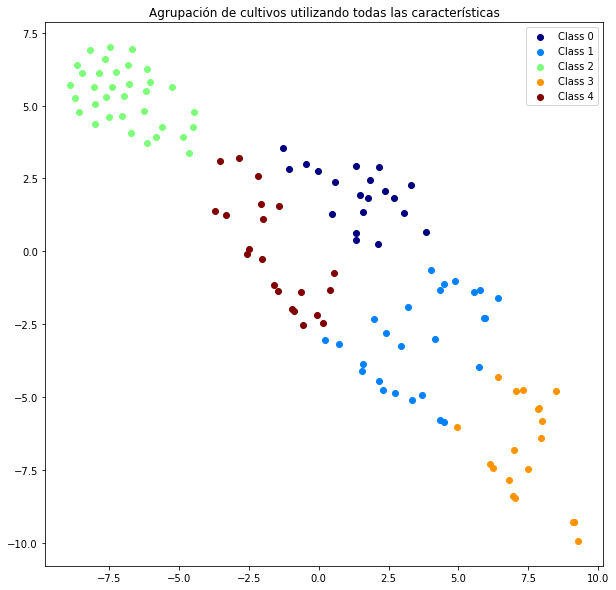

In [99]:
X = TSNE(n_components=2).fit_transform(for_cluster.iloc[:,1:])
k=5
kmeans = km(n_clusters=k, random_state=0).fit(X)
y = kmeans.labels_
list(set(y))
N= len(list(set(y)))
cmap = mplot.cm.jet
colors = cmap(np.linspace(0, 1, N))
fig = mplot.figure(figsize=(10,10))
for i in list(set(y)):
    mplot.scatter(X[y==i,0],X[y==i,1],c=colors[i],label=str('Class '+str(i)))
mplot.legend()
mplot.title('Agrupación de cultivos utilizando todas las características')
# mplot.xlim(-15,)
# mplot.ylim(-20,)
mplot.show()


# por corregir

In [100]:
#### Crops falling in same cluster
for i in range(k):
    print('Cluster ',i,list(set(for_cluster.Crop[y==i].values)),'\n')

Cluster  0 ['Peas & beans (Pulses)', 'Linseed', 'Other Cereals & Millets', 'Sesamum', 'Jack Fruit', 'Pulses total', 'Niger seed', 'Cashewnut Processed', 'Coriander', 'Small millets', 'Other  Rabi pulses', 'Samai', 'Cashewnut', 'Other Kharif pulses', 'Horse-gram', 'Oilseeds total', 'Safflower', 'Cowpea(Lobia)', 'Black pepper', 'Cardamom'] 

Cluster  1 ['Arhar/Tur', 'Moong', 'Orange', 'Pineapple', 'Sapota', 'Barley', 'Cashewnut Raw', 'Grapes', 'Mesta', 'Lemon', 'other oilseeds', 'Ragi', 'Arcanut (Processed)', 'Brinjal', 'Masoor', 'Moth', 'Urad', 'Dry chillies', 'Onion', 'Khesari', 'Sunflower', 'Arecanut', 'Tomato', 'Papaya', 'Castor seed', 'Coffee'] 

Cluster  2 ['Ber', 'other misc. pulses', 'Lentil', 'Lab-Lab', 'Jobster', 'Ash Gourd', 'Litchi', 'Other Dry Fruit', 'Redish', 'Yam', 'Peas  (vegetable)', 'Snak Guard', 'Ricebean (nagadal)', 'Ribed Guard', 'Pear', 'Turnip', 'Beet Root', 'Varagu', 'other fibres', 'Peach', 'Carrot', 'Plums', 'Water Melon', 'Cauliflower', 'Bean', 'Perilla', 'Pum

#### Encontrar los grupos de estados con el año utilizando todas las características

In [101]:
# print(merged_all.columns)
from sklearn.cluster import AgglomerativeClustering

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

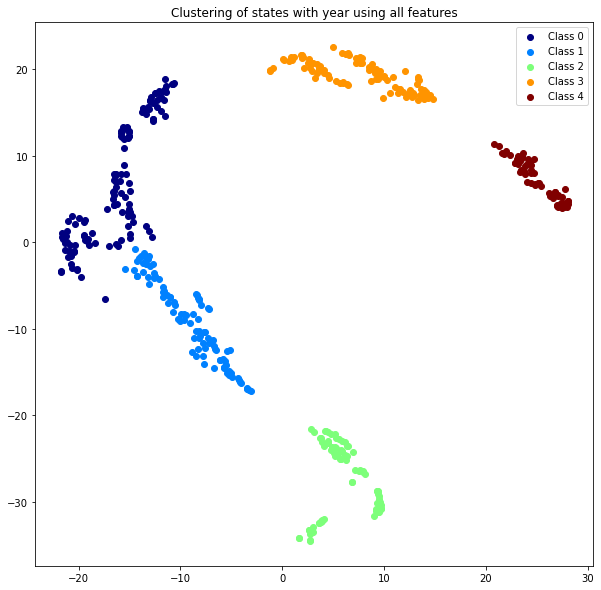

In [102]:
for_cluster = merged_all[['STATES','YEAR', 'Area', 'Production', 'Annual_Rain','Avg_Temperature', 'Price', 'Cost_per_Hectare', 'Cost_per_quintal','Suicides']]
for_cluster = for_cluster.groupby(['STATES','YEAR']).agg('mean').reset_index()
for_cluster.head()
X = TSNE(n_components=2).fit_transform(for_cluster.iloc[:,2:])
# k=4
# kmeans = km(n_clusters=k, random_state=0).fit(X)
# y = kmeans.labels_
clustering = AgglomerativeClustering(n_clusters=5).fit(X)
y=clustering.labels_
list(set(y))
N= len(list(set(y)))
cmap = mplot.cm.jet
colors = cmap(np.linspace(0, 1, N))
fig = mplot.figure(figsize=(10,10))
for i in list(set(y)):
    mplot.scatter(X[y==i,0],X[y==i,1],c=colors[i],label=str('Class '+str(i)))
mplot.legend()
mplot.title('Clustering of states with year using all features')
mplot.show()

In [103]:
#### Crops falling in same cluster
for i in range(k):
    print('Cluster ',i,list(set(for_cluster.STATES[y==i].values)),'\n')

Cluster  0 ['MAHARASHTRA', 'ORISSA', 'MADHYA PRADESH', 'TRIPURA', 'ASSAM', 'JHARKHAND', 'PUDUCHERRY', 'JAMMU & KASHMIR', 'HIMACHAL PRADESH', 'RAJASTHAN', 'BIHAR', 'HARYANA', 'GUJARAT', 'ANDHRA PRADESH', 'TELANGANA', 'CHHATTISGARH', 'KARNATAKA', 'TAMIL NADU', 'UTTARAKHAND'] 

Cluster  1 ['MAHARASHTRA', 'PUNJAB', 'ORISSA', 'KARNATAKA', 'TAMIL NADU', 'WEST BENGAL', 'PUDUCHERRY', 'HARYANA', 'GUJARAT', 'ANDHRA PRADESH', 'BIHAR'] 

Cluster  2 ['MAHARASHTRA', 'TAMIL NADU', 'UTTAR PRADESH', 'WEST BENGAL', 'ASSAM', 'GOA', 'ANDHRA PRADESH', 'ANDAMAN & NICOBAR ISLANDS', 'KERALA'] 

Cluster  3 ['MAHARASHTRA', 'NAGALAND', 'JHARKHAND', 'PUDUCHERRY', 'MANIPUR', 'TRIPURA', 'ARUNACHAL PRADESH', 'SIKKIM', 'GOA', 'MEGHALAYA', 'JAMMU & KASHMIR', 'HIMACHAL PRADESH'] 

Cluster  4 ['NAGALAND', 'CHANDIGARH', 'MANIPUR', 'MIZORAM', 'SIKKIM', 'DADRA AND NAGAR HAVELI', 'MEGHALAYA'] 



#### Encontrar los cultivos con máxima producción en cada estado

In [104]:
max_crop = merged_all[['STATES','YEAR','Crop','Production']]
max_crop = max_crop.groupby(['STATES','Crop']).agg('sum').reset_index()
max_crop.drop(columns='YEAR',inplace=True)
idx = max_crop.groupby(['STATES'])['Production'].transform(max) == max_crop['Production']
max_crop[idx]

,STATES,Crop,Production
5,ANDAMAN & NICOBAR ISLANDS,Coconut,7.177900e+08
32,ANDHRA PRADESH,Coconut,1.680600e+10
94,ARUNACHAL PRADESH,Rice,2.331049e+06
105,ASSAM,Coconut,1.654353e+09
169,BIHAR,Sugarcane,9.234307e+07
187,CHANDIGARH,Wheat,3.190500e+04
220,CHHATTISGARH,Rice,8.149862e+07
250,DADRA AND NAGAR HAVELI,Sugarcane,8.765550e+05
257,GOA,Coconut,5.031126e+08
293,GUJARAT,Sugarcane,1.725608e+08


#### Cosechas máximas producidas en los estados por año

In [105]:
max_crop_yearly = merged_all.groupby('STATES').agg('mean').reset_index()
max_crop_yearly = max_crop_yearly[['STATES']]
for i in merged_all.YEAR.unique():
    max_crop = merged_all[['STATES','YEAR','Crop','Production']]
    max_crop = max_crop[max_crop.YEAR==i]
    max_crop = max_crop.groupby(['STATES','Crop']).agg('sum').reset_index()
    max_crop.drop(columns='YEAR',inplace=True)
    idx = max_crop.groupby(['STATES'])['Production'].transform(max) == max_crop['Production']
    max_crop_yearly = pd.merge(max_crop_yearly,max_crop[idx][['STATES','Crop']].reset_index(),how='left')
    max_crop_yearly.drop(columns= {'index'},inplace=True)
    max_crop_yearly.rename(columns={'Crop':i},inplace=True)
max_crop_yearly.drop(columns={2015},inplace=True) # Since data for only Assam and Orrisa are available
max_crop_yearly

,STATES,2000,2001,2002,2003,2004,2005,2006,2010,2007,2008,2009,2011,2012,2013,2014
0,ANDAMAN & NICOBAR ISLANDS,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANDHRA PRADESH,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut,Sugarcane,Sugarcane,Coconut,Coconut,Coconut,Coconut,Coconut,Coconut
2,ARUNACHAL PRADESH,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Oilseeds total,Rice,Rice,Rice,Rice
3,ASSAM,Coconut,Coconut,Coconut,Coconut,Coconut,Rice,Coconut,Coconut,Coconut,Coconut,Coconut,Rice,Rice,Rice,Rice
4,BIHAR,Rice,Sugarcane,Rice,Rice,Sugarcane,Sugarcane,Rice,Sugarcane,Wheat,Rice,Wheat,Rice,Sugarcane,Sugarcane,Sugarcane
5,CHANDIGARH,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,Wheat,NaN,NaN,NaN,NaN
6,CHHATTISGARH,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice,Rice
7,DADRA AND NAGAR HAVELI,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Rice,Rice,Rice,Sugarcane,Sugarcane,Rice,Rice
8,GOA,NaN,NaN,NaN,NaN,Coconut,Coconut,Coconut,Rice,Coconut,Rice,Rice,Rice,Rice,Rice,Rice
9,GUJARAT,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Sugarcane,Cotton(lint),NaN,NaN


###  Fin de la presentación